# Projet_3 : **Préparez des données pour un organisme de santé publique**

**Objectif du projet :**  
Etablir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

**Commentaires sur ce notebook:**  
* Il y a une fonction pour créer un dossier 'graphs' afin d'y stocker les graphiques bokeh qui sont lourds, mais qui permettent une interactivité.
* J'ai utilisé la version MatPlotlib 3.9.0 - si version inférieure il peut y avoir des erreurs : TypeError: boxplot() got an unexpected keyword argument 'tick_labels'

#### Importer les librairies :

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from IPython.display import display, HTML, Markdown, clear_output, IFrame
import math
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
import warnings
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version")

In [ ]:
# fonction python qui permet d'écrire du markdown par une fonction dans une fonction python
def display_markdown(text):
    display(Markdown(text))

In [ ]:
# activate Bokeh output in Jupyter notebook
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource, output_file, save
from bokeh.models import NumeralTickFormatter

output_notebook()

In [ ]:
import os

if not os.path.exists('graphs'):
    try:
       os.mkdir('graphs')
    except:
        print("Merci de créer manuellement un dossier intitulé 'graphs', qui servira à stocker les graphs volumineux. ")

## **Etape 1:** Nettoyez et filtrez des features et produits

Une fois cette étape terminée, je devrais avoir :

*    identifié ma cible selon les critères demandés ;
*    mis en place un processus clair et automatisé pour filtrer les features (variables / colonnes) et des produits (lignes) qui seront utilisés pour atteindre l’objectif de mon projet.


### 1.1 - Importation, dataframe, description :

Avec une recherche sur le site de OpenFoodFacts, on trouve l'information que le fichier csv est avec un séparateur type : **Tabulation**

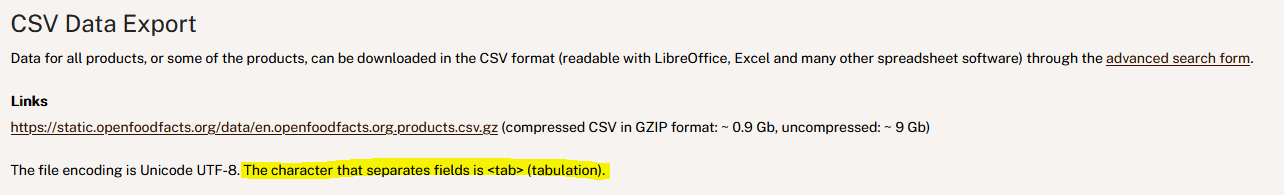

In [ ]:
# import du fichier csv dans en dataframe, separateur = TAB
# utilisation de 'engine Python' pour un import sans warning et on_bad_lines skip à cause des nombreuses valeurs manquantes
raw_data_df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', engine='python',  encoding='utf8', on_bad_lines='skip')

---

#### 1.1.1 - Affichage du *head* et *tail* :


In [ ]:
# affichage des 5 premieres et 5 dernieres lignes du dataframe
display(raw_data_df.head())
display(raw_data_df.tail())

---

#### 1.1.2 - Dimensions du dataset :

In [ ]:
# Nombre de lignes et colonnes
raw_data_df.shape

Le dataframe contient plus de 320.000 lignes et 162 colonnes

---

#### 1.1.3 - Types de données et répartitions :

In [ ]:
# quantités de colonnes quantitatives et catégorielles
raw_data_df.dtypes.value_counts()

Deux types de colonnes dans le dataset :  
* 106 colonnes quantitatives
* 56 colonnes catégorielles

---

##### Fonctions :

In [ ]:
# fonction création d'un tableau propre en html
def tab_display(list, qty_col):
    # nombre de colonnes pour l'affichage
    num_display_columns = qty_col
    num_rows = math.ceil(len(list) / num_display_columns)

    # afficher les noms des colonnes dans un tableau
    html = "<table>"
    for i in range(num_rows):
        html += "<tr>"
        for j in range(num_display_columns):
            if i*num_display_columns + j < len(list):
                html += f"<td>{list[i*num_display_columns + j]}</td>"
        html += "</tr>"
    html += "</table>"

    # affichage
    return display(HTML(html))

# fonction création d'un tableau propre en html
def tab_display_from_dict(dict_data, qty_col, ):
    # nombre de colonnes pour l'affichage
    num_display_columns = qty_col
    num_rows = math.ceil(len(dict_data) / num_display_columns)

    # Initialiser le HTML pour le tableau
    html = "<table border='1' style='border-collapse: collapse;'>"

    # Obtenir les éléments sous forme de liste de tuples
    items = list(dict_data.items())

    # Ajouter les lignes et les cellules au tableau HTML
    for i in range(num_rows):
        html += "<tr>"
        for j in range(num_display_columns):
            index = i * num_display_columns + j
            if index < len(items):
                k, v = items[index]
                #html += f"<td>{k}</td><td>{v}</td>"
                html += f"<td>{k} {v}</td>"
        html += "</tr>"
    html += "</table>"

    # Afficher le tableau HTML
    return display(HTML(html))


# Création d'une liste de termes qui peut s'apparenter à une donnée manquante
missing_List = ["", "n/a", "N/A", " ", "None", "nan", "Nan", "NaN", "NAN", "np.nan", "pd.NA", "NA", "na", "-", "--", "N/A-", "na-", "missing", "?", "unknown", "UNKNOWN"]
 
# fonction pour filtrer les valeurs non conformes et compter par colonne
def compter_valeurs_non_conformes(df, liste_non_conformes, filter=0, column=''):
    compteur_valeurs_non_conformes = {}
    total_rows = len(df)
    liste_non_conformes_lower = {x.lower() for x in liste_non_conformes}

    def calculate_non_conformity(col_data):
        lower_col_data = col_data.str.lower()
        mask = lower_col_data.isin(liste_non_conformes_lower)
        nb_non_conformes = mask.sum()
        rate_value = (nb_non_conformes / total_rows) * 100
        return nb_non_conformes, rate_value

    if column:
        nb_non_conformes, rate_value = calculate_non_conformity(df[column].astype(str))
        if filter == 0 or rate_value <= filter:
            rate_str = f"{rate_value:.2f}%"
            compteur_valeurs_non_conformes[column] = (nb_non_conformes, rate_str)
    else:
        for col in df.columns:
            nb_non_conformes, rate_value = calculate_non_conformity(df[col].astype(str))
            if filter == 0 or rate_value <= filter:
                rate_str = f"{rate_value:.2f}%"
                compteur_valeurs_non_conformes[col] = (nb_non_conformes, rate_str)

    return compteur_valeurs_non_conformes

##### 

#### 1.1.4 - Analyses des manquants ( par type de colonne ):  
  
Découpe du dataset en 2, par type :

In [ ]:
# nouveaux df avec seulement les types colonnes 'object' et 'float'
object_type_df = raw_data_df.select_dtypes(include=['object']).copy()
float_type_df = raw_data_df.select_dtypes(include=['float64']).copy()

##### Liste des colonnes **catégorielles** (considérées comme 'object') et **quantité de manquants** :

In [ ]:
# tri des colonnes par ordre alphabetique
#object_type_df.sort_index(axis=1, inplace=True)
# création d'une liste du nom des colonnes
object_list = object_type_df.columns.tolist()
print(f"le dataset contient {len(object_list)} colonnes catégorielles.")
# création d'un tuple pour chaque feature contenant le nombre de manquant et le taux
object_dict = compter_valeurs_non_conformes(object_type_df, missing_List)
object_liste_sorted = sorted(object_dict.items(), key=lambda t: t[1], reverse=True)
# affichage en tableau html
tab_display(object_liste_sorted, 6)
# compte le nombre de variables avec + de 50% de manquants


**Ci-dessus, la tableau intègre le pourcentage de manquants.**  

In [ ]:
#msno.bar(object_type_df)

##### Liste des colonnes **quantitatives** et **quantité de manquants** :

In [ ]:
# tri des colonnes par ordre alphabetique
float_type_df.sort_index(axis=1, inplace = True)
float_list = float_type_df.columns.tolist()
print(f"le dataset contient {len(float_list)} colonnes quantitatives.")
# compter valeurs non conformes
float_dict = compter_valeurs_non_conformes(float_type_df, missing_List)
float_list_sorted = sorted(float_dict.items(), key=lambda t: t[1], reverse=True)
# afficahge dans tableau
tab_display(float_list_sorted, 5)

In [ ]:
#msno.bar(float_type_df)

In [ ]:
# statistiques descriptives
float_type_df.describe()

On peut voir ici quelques valeurs aberrantes, comme des **valeurs négatives** en minimum sur des vitamines, ou des **valeurs max à 716g** pour une valeur estimée pour 100g du produit.

---
---

### 1.2 - Sélectionner les données pertinentes - **CIBLE** :
* Recherche d'une cible (type catégoriel)

#### 1.2.1 - **Cible** - Analyse métier :

Notre dataset est composé de 4 catégories :  


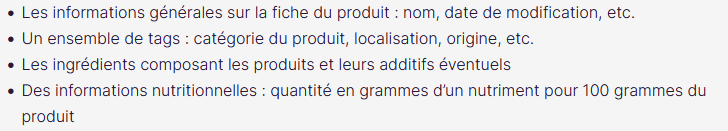

Ces données servent en particulier à noter chaque produit par un score qui détermine le fameux "Nutri-score" qui est désormais affiché sur la plupart des produits alimentaires du commerce.  

Pour notre cible, nous allons prendre une variable catégorielle, dont la liste est :

In [ ]:
print(object_type_df.columns)

Au vu de l'usage de ce dataset, qui est une sorte de classification, une cible de catégorie du produit ou de notation serait intéressante, voici les 7 **variables** que je pré-sélectionne en **point de vue Métier**:  
* categories
* categories_fr
* main_category
* main_category_fr
* nutrition_grade_fr
* pnns_groups_1
* pnns_groups_2


---
#### 1.2.2 - **Cible** - Analyse technique :

Création d'un dataframe contenant les variables pré-sélectionnées afin de les analyser.

In [ ]:
# création liste des variables pre-selectionnees
target_list = ['categories', 'categories_fr', 'main_category', 'main_category_fr', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2']
df_targets = object_type_df[target_list]
df_targets.info()

**Taux des manquants :**

In [ ]:
# compte le nombre de manquants et calcul le pourcentage
targets_missing = [tup for tup in object_liste_sorted if tup[0] in target_list]
print("Nombre de manquants et son taux pour les cibles pré-sélectionnées :")
targets_missing

In [ ]:
# affichage des manquants
#msno.bar(sorted_df_targets)

---

#### 1.2.2 - Quantité de valeur unique par colonne :

<i class="fa fa-arrow-right" aria-hidden="true"></i>
Nous cherchons une **feature cible** qu'il faudra prédire, il serait judicieux qu'il n'y ait pas une grande diversité de "value" à prédire.  

In [ ]:
# compte le nombre de valeur unique par variable
count_unique_value = {}
for column in df_targets.columns:
    serie_unique = df_targets[column].unique()
    count_unique_value[column] = len(serie_unique)

count_unique_value_df = pd.DataFrame.from_dict(count_unique_value, orient='index', columns=['count_unique'])
count_unique_value_df = count_unique_value_df.sort_values(by='count_unique')

In [ ]:
count_unique_value_df

---

#### 1.2.3 - Features avec moins de 100 "values" uniques :

<i class="fa fa-arrow-right" aria-hidden="true"></i>
Regardons les features avec **moins de 100** values différentes :

In [ ]:
# filtre sur moins de 100 valeurs uniques
count_unique_value_df[count_unique_value_df['count_unique'] < 100]

---

#### 1.2.4 - Détails des features :

<i class="fa fa-arrow-right" aria-hidden="true"></i>
Analysons le contenu de chaque feature :

**1- Feature "nutrition_grade_fr"**

In [ ]:
# compte le nombre de valeur
df_targets.nutrition_grade_fr.value_counts()

Le nutriscore est une lettre indiquant un niveau, allant de **A à E** et qui est établi en fonction de la valeur nutritionnelle d'un produit alimentaire.  
==> **ce feature parait interessant**.

**2- Feature "pnns_groups_1"**

Après avoir choisit des features qui permettront de définir la cible, j'estime que les variables "pnns_groups_1" et "pnns_groups_2" ne sont pas viables.  
Explications :

Affichage des manquants des features potentiels après avoir nettoyé le dataset :

In [ ]:
list_test =['pnns_groups_1', 'pnns_groups_2', 'product_name', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'glucose_100g', 'fiber_100g', 'proteins_100g',
                         'salt_100g', 'sodium_100g', 'alcohol_100g', 'nutrition-score-fr_100g']
pnns1_df = raw_data_df.copy()
pnns1_df = pnns1_df[list_test]
pnns1_df = pnns1_df.dropna(subset='pnns_groups_1')
pnns1_df = pnns1_df[pnns1_df['pnns_groups_1'] != 'unknown']
pnns1_dict = compter_valeurs_non_conformes(pnns1_df, missing_List)
pnns1_dict_sorted = sorted(pnns1_dict.items(), key=lambda t: t[1], reverse=True)
tab_display(pnns1_dict_sorted, 5)

In [ ]:
pnns1_df.shape

In [ ]:
msno.matrix(pnns1_df)

In [ ]:
df_targets.pnns_groups_1.str.lower().str.replace('-',' ').value_counts()

Ce feature représente des catégories de produits.  
Il y a dans leurs données présentes 22624 produits en **"UNKNOWN"**, ce qui est considéré comme des donnée manquantes.   

Pour cette cible, les facteurs qui peuvent empêcher de déduire les catégories sont notamment :
* **Manque de caractéristiques clés** : ne pas avoir par exemple le feature 'fiber_100g' (>50% de manquants) risque de biaiser la classification

**Les caractéristiques à disposition risquent de ne pas permettre une catégorisation suffisamment précise et efficace.**

==> **cette cible sera difficile à catégoriser avec notre dataset**.

**3- Feature "pnns_groups_2"**

In [ ]:
df_targets.pnns_groups_2.str.lower().str.replace('-',' ').value_counts()

Idem feature pnns_group_1, ce feature représente les catégories des produits mais en plus détaillé.  
 
Dans les données présentent il y a 22624 produits en **"UNKNOWN"**, ce qui est considéré comme des donnée manquantes.  

Avec ce grand nombre de catégories à déduire, nous aurons des difficultés à prévoir :
* **Manque de caractéristiques clés** : ne pas avoir par exemple le feature 'fiber_100g' (>50% de manquants) risque de biaiser la classification
* **Catégories ambigües** : déduire certaines catégories trop proches, ex : "dairy desserts" / "ice cream" / "milk and yogurt "
* **Catégories non représentatives** : des catégories sous représentées, ex: potatoes, eggs,...

==> **cette cible sera difficile à catégoriser avec notre dataset**. 

---

#### 1.2.5 - Choix de la cible :

Malgré les recommandations sur le choix d'une cible avec plus de 50% de valeurs manquantes


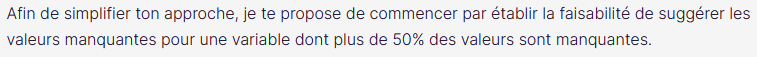
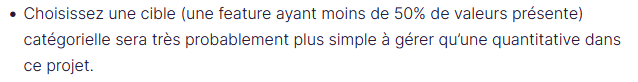

Avec un taux de données présentes en dessous les 30%, les variables `pnns_groups_1`et `pnns_groups_2` risque de ne pas être viables et ne fourniront pas assez d'informations pour un éventuel algorithme de ML.

Mon choix se tourne donc vers :  
**`nutrition_grade_fr`**  


---
---

### 1.3 - Sélectionner les données pertinentes - **FEATURES** :
* Recherche de features (type quantitatif)

#### 1.3.1 - Préparation Dataframe pour les features :

Suppression des produits n'ayant pas de valeur cible :

In [ ]:
raw_predict_data_df = raw_data_df.dropna(subset=['nutrition_grade_fr'] ).copy()

In [ ]:
raw_predict_data_df.shape

#### 1.3.2 - **Features de prédiction** - Analyse métier :

Recherche de features qui pourront apporter les informations nécessaires pour prédire notre cible.  
La liste des features quantitatifs disponible dans le dataset :

In [ ]:
# liste des variables quantitatives
predict_columns_list = raw_predict_data_df.columns.to_list()
tab_display(predict_columns_list, 7)

Un algorithme de prédiction demande des **inputs** quantitatifs ou des catégoriels transformés en quantitatifs.  
Ici les features candidats  catégoriels n'ont pas d'intérêt pour notre prédiction, l'analyse va se diriger uniquement sur les **features candidats quantitatifs**.

Pour la sélection des features, je me base sur le **tableau des nutriments** obligatoire en France, en ajoutant le "nutrition-score-fr_100g" qui est la valeur qui donne la **Lettre de notre cible**.

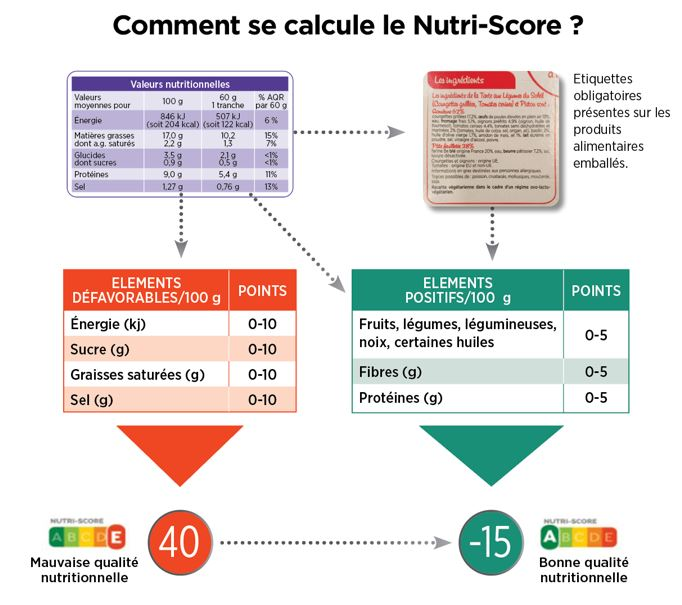

Les variables que je pré-sélectionne sont : 
* energy_100g
* energy-from-fat_100g
* fat_100g
* saturated-fat_100g
* trans-fat_100g
* cholesterol_100g
* carbohydrates_100g
* sugars_100g
* glucose_100g
* fiber_100g
* proteins_100g
* salt_100g
* sodium_100g
* alcohol_100g
* nutrition-score-fr_100g
* nutrition-score-uk_100g

J'en ai donc **16**.

#### 1.3.3 - **Features** - Analyse technique :

Création du dataset pour l'analyse technique :

In [ ]:
# liste des variables pre-selectionnees
filtered_features_list = ['energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'glucose_100g', 'fiber_100g', 'proteins_100g',
                         'salt_100g', 'sodium_100g', 'alcohol_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
filtered_features = raw_predict_data_df[filtered_features_list]

Les recommandations nous dirigent vers des features remplis à plus de 50%.  

In [ ]:
filtered_features = filtered_features.sort_index(axis=1)
# tri du dataframe par quantité de valeurs présentes dans les colonnes
sorted_df_filtered_targets = filtered_features[filtered_features.isnull().sum().sort_values().index]
missing_rate_features = sorted_df_filtered_targets.isnull().sum()/len(sorted_df_filtered_targets)*100
print("Taux de manquants des features pré-sélectionnées :")
missing_rate_features

In [ ]:
# option de la librairie missingno de filtrer les features > 50%
missing_filtered_features = msno.nullity_filter(filtered_features, filter='top', p=0.5) # or filter='top'
#msno.bar(missing_filtered_features)

Il reste 13 features possibles:

In [ ]:
quantitative_predict_features_list = missing_filtered_features.select_dtypes(include='float64').columns.tolist()
tab_display(quantitative_predict_features_list, 4)

---

#### 1.3.2 - Analyse et choix des features :

Afin de se concentrer sur les principaux éléments nécessaire au nutriscore, mon choix part sur 8 features  :
```
predict_features_list = ['carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
```

**J'ai désormais 8 features**  
  

#### 1.3.3 - Création dataframe avec **cible + features** :

Création d'un dataframe avec uniquement les features de prédiction, le feature cible et la colonne **product_name** .

In [ ]:
predict_features_df  = raw_predict_data_df.copy()
raw_predict_list = ['product_name', 'nutrition_grade_fr', 'carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
raw_predict_df = predict_features_df[raw_predict_list]

---
---

### 1.4 - Suppression des produits en doubles :

Vérification s'il y a des manquants dans la colonne `product_name` :

In [ ]:
compter_valeurs_non_conformes(raw_predict_df, missing_List, column='product_name')

In [ ]:
raw_predict_df.product_name.isna().sum()

**Remarque :**  
La fonction `compter_valeurs_non_conformes` qui prend en compte un large choix de données **"NON CONFORMES"** détecte autant de données manquantes que la fonction native **"isna"** : **2747**.

Suppression des valeur non conformes de la colonne `product_name`.

In [ ]:
# dimensions du dataframe AVANT suppression des valeurs non conformes
raw_predict_df.shape

In [ ]:
raw_predict_df = raw_predict_df.dropna(subset=['product_name'])
for elem in missing_List:
    raw_predict_df = raw_predict_df[raw_predict_df['product_name'] != elem]

In [ ]:
# dimensions du dataframe APRES suppression des valeurs non conformes
raw_predict_df.shape

---

#### 1.4.1 - Compter et supprimer les doublons :

In [ ]:
# compte le nombre de doublons
len(raw_predict_df) - len(raw_predict_df.drop_duplicates(keep='first'))

On trouve 14493 doublons à supprimer dans le dataset.

In [ ]:
# suppression des doublons
processed_predict_df = raw_predict_df.drop_duplicates(keep='first')

In [ ]:
processed_predict_df.shape

On se retrouve avec un dataframe sans doublons : `processed_predict_df`

---
---

### 1.5 - Séparation "cible" et "features" :

Séparation du dataset en 2, en gardant la colonne 'product_name' comme référence :
* dataset **cible** : `nutrition_grade_fr`
* dataset **features** : `predict_features_df`

In [ ]:
# dataframe cible
target_list = ['product_name', 'nutrition_grade_fr']
target_df = processed_predict_df[target_list].copy().set_index('product_name')
target_df['nutrition_grade_fr'] = target_df['nutrition_grade_fr'].str.upper()

In [ ]:
target_df.shape

In [ ]:
target_df.head()

In [ ]:
# création d'une liste contenant les features de prédictions
predict_features_list = ['product_name', 'carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
# dataframe de prédiction
predict_features_df = processed_predict_df[predict_features_list].copy().set_index('product_name')

In [ ]:
predict_features_df.shape

In [ ]:
predict_features_df.head()

---
---

### 1.6 - Automatisation du processus de nettoyage :

#### 1.6.1 - Description du processus :

Etapes de nettoyage à automatiser :
* Suppression des produits n'ayant pas de valeur cible
* Filtrage pour ne garder que la "cible" et les "features"
* Suppression des manquants de la colonne `product_name`
* Suppression des doublons
* Formatage de la cible en Majuscule pour une cohérence du nutriscore
* Séparation du dataframe en 2 : **cible** et **features**

---

#### 1.6.2 - Fonction d'automatisation de nettoyage :

In [ ]:
def cleaning_process(df):
    # variables 
    missing_List = ["", "n/a", "N/A", " ", "None", "nan", "Nan", "NaN", "NAN", "np.nan", "pd.NA", "NA", "na", "-", "--", "N/A-", "na-", "missing", "?", "unknown"]
    predict_list = ['product_name', 'nutrition_grade_fr', 'carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
    target_list = ['product_name', 'nutrition_grade_fr']
    predict_features_list = ['product_name', 'carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
    
    # Suppression des produits n'ayant pas de valeur cible
    df = df.dropna(subset=['nutrition_grade_fr'])
    
    # Filtrage pour ne garder que la "cible" et les prédiction
    df = df[predict_list]
    
    # Suppression des manquants de la colonne product_name
    df = df.dropna(subset=['product_name'])
    df = df[~df['product_name'].isin(missing_List)]

    # suppression des doublons
    df_processed = df.drop_duplicates(keep='first')

    # formatage majuscule de la cible
    df_processed.loc[:,'nutrition_grade_fr'] = df_processed['nutrition_grade_fr'].str.upper()

    # Séparation du dataframe en 2 : cible et features
    target_df = df_processed[target_list].set_index('product_name')
    predict_features_df = df_processed[predict_features_list].set_index('product_name')

    return target_df, predict_features_df, df_processed
    

#### 1.6.3 - Test de la fonction avec le dataframe original `raw_data_df` :

In [ ]:
# lancement de la fonction
target_df, predict_features_df, full_dataset = cleaning_process(raw_data_df)

**Dataset cible :**

In [ ]:
target_df.shape

In [ ]:
target_df.head()

On retrouve bien un dataframe avec la **cible** en feature et "product_name" en index, ainsi que le même nombre de ligne que précédemment.

**Dataset avec les features:**

In [ ]:
predict_features_df.shape

In [ ]:
predict_features_df.head()

On retrouve bien un dataframe avec les **features** et "product_name" en index, ainsi que le même nombre de ligne que précédemment.

In [ ]:
full_dataset.set_index('product_name', inplace=True)
full_dataset.shape

---
---
---

## **Etape 2 :** Identifiez et traitez les valeurs aberrantes :

Il est important de bien identifier les valeurs aberrantes, nous allons analyser ici 2 types :
* valeur extrême mais cohérente et possible
* valeur extrême impossible en réalité  
  
L'approche **"métier"** est indispensable pour les détecter.

### 2.1 - Dataset des features - Introduction :

Observation des statistiques descriptives des features :

In [ ]:
# statistiques descriptives
predict_features_df.describe()

Ce tableau nous montre des valeurs élevées, des valeurs négatives, une analyse plus approfondie des valeurs aberrantes (outliers) est de rigueur.  
Chacune de ces colonnes sont des valeurs données pour 100g de produit alimentaire, mais sont toutefois à traiter différemment, nous allons ici les analyser en **2 catégories** :  
* 1ère catégorie : energy_100g
* 2ème catégorie : carbohydrates_100g, fat_100g, fiber_100g, proteins_100g, salt_100g, saturated-fat_100g, sugars_100g

**Objectif de l'analyse** : 
L'objectif est de déterminer quelles sont les limites théoriques et pratiques des outliers et comment les traiter, par catégorie.  
L'approche va se réaliser de cette façon :  
- Analyse statistique:
    - Seuils à +/- 3 écarts-types
    - Plages interquartiles
- Analyse orientée métier:
    - Recherche des détails du feature
- Décision de traitement des ouliers:
    - Comparaison des méthodes
    - Décision
    - Application par une fonction

---
---

##### Fonctions graphiques

In [ ]:

def scatterplot_widget(df_, feature, title, log=False, level=None):
    df = df_.copy()
    df.reset_index(inplace=True)

    source = ColumnDataSource(df)

    if log:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log")
    else:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    p.scatter(x='index', y=feature, source=df)

    # ajout 'level' pour colorier des points
    if level is not None:
        above_level = df[df[feature] > level]
        source_above = ColumnDataSource(above_level)
        p.scatter(x='index', y=feature, source=source_above, color='red')

    p.yaxis.formatter = NumeralTickFormatter(format="0,0")

    button = widgets.Button(description="Afficher le graphique")
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output(wait=True)
            show(p)
    
    button.on_click(on_button_clicked)
    display(button, output)


def scatterplot(df_, feature, title, log=False, level=None):
    df = df_.copy()
    df.reset_index(inplace=True)

    source = ColumnDataSource(df)

    if log == True:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log")
    else:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    p.scatter(x='index', y=feature, source=df)

    # ajout 'level' pour colorier des points
    if level is not None:
        above_level = df[df[feature] > level]
        source_above = ColumnDataSource(above_level)
        p.scatter(x='index', y=feature, source=source_above, color='red')

    
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    show(p)

def scatterplot_html(df_, feature, title, file, log=False, level=None):
    df = df_.copy()
    df.reset_index(inplace=True)

    source = ColumnDataSource(df)

    if log == True:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log")
    else:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    p.scatter(x='index', y=feature, source=df)

    # ajout 'level' pour colorier des points
    if level is not None:
        above_level = df[df[feature] > level]
        source_above = ColumnDataSource(above_level)
        p.scatter(x='index', y=feature, source=source_above, color='red')

    
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    output_file(file)
    save(p)

def boxplotbokeh(df, feature, title, log=False, limite=None):
    # les données pour Bokeh
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.5)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)

    outliers = df[(df[feature] > upper) | (df[feature] < lower)]

    # whiskers sans les outliers
    whisker_upper = min(df[feature][df[feature] <= upper].max(), upper)
    whisker_lower = max(df[feature][df[feature] >= lower].min(), lower)


    # source outliers
    outlier_source = ColumnDataSource(data=dict(
        x=[0] * len(outliers),
        y=outliers[feature]
    ))

    # créer la figure
    if log == True:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log" )
    else:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    # les whiskers
    p.segment(0, whisker_upper, 0, q3, line_color="black")
    p.segment(0, whisker_lower, 0, q1, line_color="black")
    # ligne d'une limite, ex 4000kj pour l'energy
    if limite is not None:
        p.segment(x0=-1, x1=1, y0=limite, y1=limite, line_color="orange")


    # les boxes (quartiles)
    p.vbar(x=0, width=0.5, bottom=q2, top=q3, fill_color="blue", line_color="black")
    p.vbar(x=0, width=0.5, bottom=q1, top=q2, fill_color="blue", line_color="black")

    # les whisker
    p.rect(x=0, y=whisker_upper, width=0.3, height=0.01, line_color="black")
    p.rect(x=0, y=whisker_lower, width=0.3, height=0.01, line_color="black")

    # les outliers
    p.scatter(x='x', y='y', size=6, source=outlier_source, color="red", alpha=0.6)
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")

    # afficher la figure
    show(p)

def boxplotbokeh_html(df, feature, title, file, log=False, limite=None):
    # les données pour Bokeh
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.5)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)

    outliers = df[(df[feature] > upper) | (df[feature] < lower)]

    # whiskers sans les outliers
    whisker_upper = min(df[feature][df[feature] <= upper].max(), upper)
    whisker_lower = max(df[feature][df[feature] >= lower].min(), lower)


    # source outliers
    outlier_source = ColumnDataSource(data=dict(
        x=[0] * len(outliers),
        y=outliers[feature]
    ))

    # créer la figure
    if log == True:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log" )
    else:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    # les whiskers
    p.segment(0, whisker_upper, 0, q3, line_color="black")
    p.segment(0, whisker_lower, 0, q1, line_color="black")
    # ligne d'une limite, ex 4000kj pour l'energy
    if limite is not None:
        p.segment(x0=-1, x1=1, y0=limite, y1=limite, line_color="orange")


    # les boxes (quartiles)
    p.vbar(x=0, width=0.5, bottom=q2, top=q3, fill_color="blue", line_color="black")
    p.vbar(x=0, width=0.5, bottom=q1, top=q2, fill_color="blue", line_color="black")

    # les whisker
    p.rect(x=0, y=whisker_upper, width=0.3, height=0.01, line_color="black")
    p.rect(x=0, y=whisker_lower, width=0.3, height=0.01, line_color="black")

    # les outliers
    p.scatter(x='x', y='y', size=6, source=outlier_source, color="red", alpha=0.6)
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")

    output_file(file)
    save(p)

def display_markdown_with_variable(variable):
    markdown_text = f"# Titre en Markdown\n\nLa valeur de la variable est **{variable}**."
    display(Markdown(markdown_text))

def std_method(df_, feature, title, file, log=False):
    df = df_.copy()
    # compte les nan
    qty_nan = df[feature].isnull().sum()
    # calcul moyenne
    df_mean = df[feature].mean()
    # calcul écart-type
    df_std = df[feature].std()

    # calcul des seuils
    Hlevel = df_mean + (3 * df_std)
    Llevel = df_mean - (3 * df_std)

    # calcul nombre d'outliers
    df_outliers = df[(df[feature] > Hlevel) | (df[feature] < Llevel)]

    # affichage des données 
    text1 = f"Le seuil supérieur à + 3 écarts-types de la moyenne est =  {round(Hlevel,1)}"
    display(Markdown(text1))
    text2 = f"Le seuil inférieur à - 3 écarts-types de la moyenne est =  {round(Llevel,1)}"
    display(Markdown(text2))
    text3 = f"Le nombre d'outliers théoriques avec cette méthodes est de : {len(df_outliers)}"
    display(Markdown(text3))  
    text4 = f"Le nombre de valeurs manquantes est de : {qty_nan}"
    display(Markdown(text4))  
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('**La liste des outliers :**')
    display_markdown('\n')
    display(df_outliers[feature])
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('**Visualisation des outliers théoriques en rouge sur le graphique ci-dessous :**')
    display_markdown('\n')
    scatterplot_html(df_, feature, title, file, log=log, level=Hlevel)


def iqr_method(df_, feature, title, file, log=False):
    # compte les nan
    qty_nan = df_[feature].isnull().sum()
    if log == True:
        df = df_[df_[feature] > 0]
    else:
        df = df_

    # calcul des q1 et q3
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1

    # calcul des seuils
    HQ3_level = q3 + (1.5 * IQR)
    LQ1_level = q1 - (1.5 * IQR)

    # calcul nombre d'outliers
    df_outliers = df[(df[feature] > HQ3_level) | (df[feature] < LQ1_level)]

    # affichage des données 
    text1 = f"Q1 = {q1}"
    display(Markdown(text1))
    text2 = f"Q3 = {q3}"
    display(Markdown(text2))
    text3 = f"Le seuil supérieur à 1,5 fois au-dessus Q3 =  {round(HQ3_level,1)}"
    display(Markdown(text3))
    text4 = f"Le seuil inférieur à 1,5 fois en-dessous Q1 =  {round(LQ1_level,1)}"
    display(Markdown(text4))
    text5 = f"Le nombre d'outliers théoriques avec cette méthodes est de : {len(df_outliers)}"
    display(Markdown(text5))
    text8 = f"Le nombre de valeurs manquantes est de : {qty_nan}"
    display(Markdown(text8))  
    display_markdown('\n')
    display_markdown('\n')
    text6 = '**La liste des outliers :**'
    display(Markdown(text6))
    display_markdown('\n')
    display(df_outliers[feature])
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('\n')
    text7 = '**Visualisation des outliers théoriques en rouge sur le graphique ci-dessous :**'
    display(Markdown(text7))
    display_markdown('\n')

    boxplotbokeh_html(df, feature, title, file, log=log, limite=HQ3_level)


#####  

### 2.2 - Analyse des outliers - **Approche méthodes statistiques :**

Ici nous allons voir 2 méthodes statistiques de détection d'outliers :
* seuils par **écarts-types** (z-score) : en général les valeurs au dessus ou en dessous **3 écarts-types autour de la moyenne** => $x < \mu - 3\sigma \text{ ou } x > \mu + 3\sigma$ avec moyenne (μ) et écart-type (σ)
* seuils **interquartiles** (IQR) : en général les valeurs en dehors 1,5 fois l'IQR =>  $x < Q1 - 1.5 \times IQR \text{ ou } x > Q3 + 1.5 \times IQR$

#### 2.2.1 - Feature "energy_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['energy_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

**ATTENTION GRAPHIQUE EN ECHELLE LOGARITHMIQUE**

In [ ]:
scatterplot_html(predict_features_df, 'energy_100g', 'Nuage de points du Feature : energy_100g', 'graphs/energy_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_scatplot = "graphs/energy_scatplot.html"
IFrame(src=html_energy_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'energy_100g', 'Nuage de points du Feature : energy_100g', 'graphs/energy_std.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_std = "graphs/energy_std.html"
IFrame(src=html_energy_std, width=800, height=500)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'energy_100g', 'Boxplot of energy_100g', 'graphs/energy_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_iqr = "graphs/energy_iqr.html"
IFrame(src=html_energy_iqr, width=800, height=600)

---

#### 2.2.2 - Feature "carbohydrates_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['carbohydrates_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'carbohydrates_100g', 'Nuage de points du Feature : carbohydrates_100g', 'graphs/carbo_scatplot.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_carbo_scatplot = "graphs/carbo_scatplot.html"
IFrame(src=html_carbo_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'carbohydrates_100g', 'Nuage de points du Feature : carbohydrates_100g', 'graphs/carbo_std.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_carbo_std = "graphs/carbo_std.html"
IFrame(src=html_carbo_std, width=800, height=500)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'carbohydrates_100g', 'Boxplot of carbohydrates_100g', 'graphs/carbo_iqr.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_carbo_std = "graphs/carbo_std.html"
IFrame(src=html_carbo_std, width=800, height=500)

---

#### 2.2.3 - Feature "fat_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['fat_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'fat_100g', 'Nuage de points du Feature : fat_100g', 'graphs/fat_scatplot.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fat_scatplot = "graphs/fat_scatplot.html"
IFrame(src=html_fat_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'fat_100g', 'Nuage de points du Feature : fat_100g', 'graphs/fat_std.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fat_std = "graphs/fat_std.html"
IFrame(src=html_fat_std, width=800, height=600)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'fat_100g', 'Boxplot of fat_100g', 'graphs/fat_iqr.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fat_iqr = "graphs/fat_iqr.html"
IFrame(src=html_fat_iqr, width=800, height=600)

---

#### 2.2.4 - Feature "fiber_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['fiber_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'fiber_100g', 'Nuage de points du Feature : fiber_100g', 'graphs/fiber_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fiber_scatplot = "graphs/fiber_scatplot.html"
IFrame(src=html_fiber_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'fiber_100g', 'Nuage de points du Feature : fiber_100g', 'graphs/fiber_std.html',log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fiber_std = "graphs/fiber_std.html"
IFrame(src=html_fiber_std, width=800, height=600)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'fiber_100g', 'Boxplot of fiber_100g', 'graphs/fiber_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_fiber_iqr = "graphs/fiber_iqr.html"
IFrame(src=html_fiber_iqr, width=800, height=600)

---

#### 2.2.5 - Feature "proteins_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['proteins_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'proteins_100g', 'Nuage de points du Feature : proteins_100g', 'graphs/proteins_scatplot.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_proteins_scatplot = "graphs/proteins_scatplot.html"
IFrame(src=html_proteins_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'proteins_100g', 'Nuage de points du Feature : proteins_100g', 'graphs/proteins_std.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_file = "graphs/proteins_std.html"
IFrame(src=html_file, width=800, height=600)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'proteins_100g', 'Boxplot of proteins_100g', 'graphs/proteins_iqr.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_proteins_iqr = "graphs/proteins_iqr.html"
IFrame(src=html_proteins_iqr, width=800, height=600)

---

#### 2.2.6 - Feature "salt_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['salt_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'salt_100g', 'Nuage de points du Feature : salt_100g', 'graphs/salt_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_salt_scatplot = "graphs/salt_scatplot.html"
IFrame(src=html_file, width=800, height=600)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'salt_100g', 'Nuage de points du Feature : salt_100g', 'graphs/salt_std.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_salt_std = "graphs/salt_std.html"
IFrame(src=html_salt_std, width=800, height=500)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'salt_100g', 'Boxplot of salt_100g', 'graphs/salt_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_salt_iqr = "graphs/salt_iqr.html"
IFrame(src=html_salt_iqr, width=800, height=600)

---

#### 2.2.7 - Feature "saturated-fat_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['saturated-fat_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'saturated-fat_100g', 'Nuage de points du Feature : saturated-fat_100g', 'graphs/satfat_scatplot.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_satfat_scatplot = "graphs/satfat_scatplot.html"
IFrame(src=html_satfat_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'saturated-fat_100g', 'Nuage de points du Feature : saturated-fat_100g', 'graphs/satfat_std.html')

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_satfat_std = "graphs/satfat_std.html"
IFrame(src=html_satfat_std, width=800, height=500)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'saturated-fat_100g', 'Boxplot of saturated-fat_100g', 'graphs/satfat_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_satfat_iqr = "graphs/satfat_iqr.html"
IFrame(src=html_satfat_iqr, width=800, height=600)

---

#### 2.2.8 - Feature "sugars_100g" :

**Rappel des statistiques descriptives :**

In [ ]:
predict_features_df['sugars_100g'].describe()

**Aperçu des données du feature dans un nuage de points :**

In [ ]:
scatterplot_html(predict_features_df, 'sugars_100g', 'Nuage de points du Feature : sugars_100g', 'graphs/sugars_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_sugars_scatplot = "graphs/sugars_scatplot.html"
IFrame(src=html_sugars_scatplot, width=800, height=500)

##### **A - Méthode +/- 3 écarts-types :**

In [ ]:
# fonction calculs methode std
std_method(predict_features_df, 'sugars_100g', 'Nuage de points du Feature : sugars_100g', 'graphs/sugars_std.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_sugars_std = "graphs/sugars_std.html"
IFrame(src=html_file, width=800, height=500)

##### **B - Méthode Interquartiles :**

In [ ]:
# fonction calculs methode IQR
iqr_method(predict_features_df, 'sugars_100g', 'Boxplot of sugars_100g', 'graphs/sugars_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_sugars_iqr = "graphs/sugars_iqr.html"
IFrame(src=html_sugars_iqr, width=800, height=600)

---

#### 2.2.9 - Récapitulatif analyse statistique :

**Tableau résultats :**

|                | energy_100g|carbohydrates_100g| fat_100g|fiber_100g|proteins_100g|salt_100g|saturated-fat_100g|sugars_100g|
|:---------------|:----------:|:----------------:|:-------:|:--------:|:-----------:|:-------:|:----------------:|:---------:|
|**STD**         |            |                  |         |          |             |         |                  |           |
|Sup threshold   |23019.6     |118               |61.2     |43.3      |32           |431      |28                |78.7       |
|Inf threshold   |-20621.8    |-51.2             |-34.5    |-37.7     |-16.4        |-427.6   |-18               |-48.6      |
|**Outliers Qty**|4           |4                 |2724     |186       |2644         |15       |2328              |2357       |
|                |            |                  |         |          |             |         |                  |           |
|**IQR**         |            |                  |         |          |             |         |                  |           |
|Q1              |481         |7.14              |1        |1.5       |2            |0.18     |1.49              |2.94       |
|Q3              |1728        |59                |21.43    |5.4       |10.71        |1.48     |10                |27.5       |
|Sup threshold   |3598.5      |136.8             |52.1     |11.2      |23.8         |3.4      |28                |64.3       |
|Inf threshold   |-1389.5     |-70.6             |-29.6    |-4.4      |-11.1        |-1.8     |-18               |-33.9      |
|**Outliers Qty**|672         |3                 |4747     |6292      |10536        |10212    |2328              |6540       |
|                |            |                  |         |          |             |         |                  |           |
|Qty NAN         |181         |17409             |17381    |25870     |181          |181      |181               |181        |

**Commentaires :**  
Les deux méthodes donnent en majorité des résultats différents.

---
---

### 2.3 - Analyse des outliers - **Approche métier :**

Avec une approche **métier**, on peut définir 2 catégories de features pour le traitement des outliers :

#### 2.3.1 - Feature **energy_100g** :

In [ ]:
predict_features_df['energy_100g'].describe()

Le feature `energy_100g` est l'apport énergétique que nous fournissent les aliments, son unité est ici le KiloJoule (KJ).  
Elle est évaluée pour 100g d'aliment, il est évident qu'elle ne peut pas être négative, elle peut toutefois avoir des valeurs élevées, on constate sa moyenne à 1192.  
Une analyse plus approfondie indique que les aliments les plus caloriques pour 100g sont les huiles avec un maximum un peu en dessous 4000kj.
  
**Point de vue métier, les valeurs en dessous 0 ou au dessus 4000 sont à considérer comme impossibles.**

In [ ]:
# calcul des outliers
df_outliers_energy = predict_features_df[(predict_features_df['energy_100g'] > 4000) | (predict_features_df['energy_100g'] < 0)]
text1 = f"Le nombre d'outliers théoriques avec cette méthodes est de : {len(df_outliers_energy)}"
display(Markdown(text1))
display_markdown('\n')
text2 = '**La liste des outliers :**'
display(Markdown(text2))
display(df_outliers_energy['energy_100g'])

In [ ]:
scatterplot_html(predict_features_df, 'energy_100g', 'Nuage de points du Feature : energy_100g', 'graphs/energy_outliers_scatplot.html',log=True, level=4000)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_outliers_scatplot = "graphs/energy_outliers_scatplot.html"
IFrame(src=html_energy_outliers_scatplot, width=800, height=500)

---

#### 2.3.2 - Features **carbohydrates_100g, fat_100g, fiber_100g, proteins_100g, salt_100g, saturated-fat_100g, sugars_100g** :

In [ ]:
nutrients = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
df_nutrients = predict_features_df[nutrients].copy()
df_nutrients.describe()

Ces valeurs de nutriments sont évalués sur des produits donnés pour 100g, et ne peuvent donc pas être supérieur à 100g, ni être négatives.  
Nous constatons avec les statistiques descriptives que nous avons des valeurs aberrantes, par exemple sur le feature `sugars_100g` :
* Min à -17.86g
* Max à 3520g

  
De plus la somme des nutriments de la liste ci-dessous représente le produit total et donc ne peut être supérieur à 100g:
* Carbohydrates (carbohydrates_100g) : inclut les sucres et les autres glucides.
* Fat (fat_100g) : inclut les graisses totales.
* Fiber (fiber_100g) : représente les fibres alimentaires.
* Proteins (proteins_100g) : représente les protéines.
* Salt (salt_100g) : représente le sel (NaCl).
  
  
**Point de vue métier, les valeurs au dessus 100g sont impossibles ainsi que le somme par produit > 100g.**

**ATTENTION** pour le calcul de la somme par produits il faut prendre en compte les valeurs manquantes par feature.  
S'il y a une donnée manquante sur un nutriment, cela fausse la somme.

In [ ]:
# masque des données manquantes 
mask_null = df_nutrients.isnull()
df_nutrients['sum_null'] = mask_null.sum(axis=1)
df_nutrients.sum_null.value_counts()

Certaines valeurs "NAN" sont peut-être à interpréter comme des valeurs **0**, mais certainement pas toutes.

In [ ]:
def nutrients_outliers(df_):
    nutrients = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
    sum_list = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
    # créez une copie des colonnes pertinentes
    df = df_[nutrients].copy()
    # ajoutez une colonne avec la somme des nutriments spécifiés
    df['sum_100g'] = df[sum_list].sum(axis=1, skipna=True)
    # créez un masque pour identifier les valeurs > 101
    mask = df > 100
    # comptez les outliers par colonne
    count_outliers_dict = mask.sum().to_dict()
    # créez un DataFrame des outliers
    outliers_df = df[mask.any(axis=1)].apply(lambda row: row[row > 101], axis=1)
    return count_outliers_dict, outliers_df

In [ ]:
count_outliers, outliers_df = nutrients_outliers(df_nutrients)
count_outliers

In [ ]:
outliers_df['sum_100g']

**Avec cette approche, nous trouvons :**
* 18637 produits dont la somme est > 100 où donc au moins une valeur du produit est mauvaise.
* dont 75 produits avec des valeurs de nutriments impossibles

**Attention avec ce calcul, les valeurs manquantes sont interprétées comme des "0".**

---
---

### 2.4 - Analyse des outliers - **Méthodes de traitement choisies :**

#### 2.4.1 - Choix méthode de traitement pour Feature **energy_100g** :

**Tableau récapitulatif :**

|          |                 | energy_100g| 
|---------:|:----------------|:----------:|
|**Method**|**STD**          |            | 
|          |Sup threshold    |23019.6     |
|          |Inf threshold    |-20621.8    |
|          |**Outliers Qty** |4           |
|          |                 |            | 
|**Method**|**IQR**          |            | 
|          |Sup threshold    |3598.5      |
|          |Inf threshold    |-1389.5     |
|          |**Outliers Qty** |672         |
|          |                 |            | 
|**Method**|**METIER**       |            | 
|          |Sup threshold    |4000        |
|          |Inf threshold    |0           |
|          |**Outliers Qty** |118         |
|          |                 |            | 
|          |Qty NAN          |181         | 

L'huile étant l'aliment le plus énergétique avec presque 4000Kj, seule l'approche "métier" est cohérente.  
==> **Choix : approche Métier - Suppression des 118 produits avec outliers.**  

Ici, les valeurs manquantes n'affectent pas le choix, car même si elles auraient pu modifier les valeurs statistiques, la logique tend vers l'approche métier qui n'est pas influencée par ces manquants.

---

#### 2.4.2 - Choix de méthode de traitement pour les **7** Features **carbohydrates_100g, fat_100g, fiber_100g, proteins_100g, salt_100g, saturated-fat_100g, sugars_100g** :

**Tableau résultats :**

|          |                | carbohydrates_100g|fat_100g|fiber_100g|proteins_100g|salt_100g|saturated-fat_100g|sugars_100g|sum_100g|
|---------:|:---------------|:-----------------:|:------:|:--------:|:-----------:|:-------:|:----------------:|:---------:|:------:|
|**Method**|**STD**         |                   |        |          |             |         |                  |           |        |
|          |Sup threshold   |118                |61.2    |43.3      |32           |431      |28                |78.7       |        |
|          |Inf threshold   |-51.2              |-34.5   |-37.7     |-16.4        |-427.6   |-18               |-48.6      |        |
|          |**Outliers Qty**|4                  |2724    |186       |2644         |15       |2328              |2357       |        |
|          |                |                   |        |          |             |         |                  |           |        |
|**Method**|**IQR**         |                   |        |          |             |         |                  |           |        |
|          |Sup threshold   |136.8              |52.1    |11.2      |23.8         |3.4      |28                |64.3       |        |
|          |Inf threshold   |-70.6              |-29.6   |-4.4      |-11.1        |-1.8     |-18               |-33.9      |        |
|          |**Outliers Qty**|3                  |4747    |6292      |10536        |10212    |2328              |6540       |        |
|          |                |                   |        |          |             |         |                  |           |        |
|**Method**|**METIER**      |                   |        |          |             |         |                  |           |        |
|          |Sup threshold   |100                |100     |100       |100          |100      |100               |100        |100     |
|          |Inf threshold   |0                  |0       |0         |0            |0        |0                 |0          |0       |
|          |**Outliers Qty**|10                 |4       |2         |1            |50       |2                 |6          |18637   |
|          |                |                   |        |          |             |         |                  |           |        |
|          |Qty NAN         |17409              |17381   |25870     |181          |181      |181               |181        |        |

En veillant à ce que chaque nutriment ainsi que la somme des nutriments par produit ne dépassent pas 100g, cette approche métier est la plus cohérente.  
==> **Choix : approche Métier - Suppression des 18637 produits avec outliers.**  

Ici, les valeurs manquantes n'affectent pas le choix par "nutriment", car même si elles auraient pu modifier les valeurs statistiques, la logique tend vers l'approche métier qui n'est pas influencée par ces manquants.  
Mais sur la somme par produit les manquants sont importants.

---
---

### 2.5 - Automatisation du traitement des outliers :

#### 2.5.1 - Stratégie par feature :

Prise en compte de 2 catégories pour le traitement :  
1. Feature energy_100g : **suppression de la ligne si 'energy_100g' < 0 ou > 4000**
2. Features fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, proteins_100g, salt_sodium_100g : **suppression de la ligne si une valeur 'nutrients' < 0 ou > 100 OU si somme par produit > 100**

---

#### 2.5.2 - Fonction de traitement des outliers :

In [ ]:
def outliers_process(df_):
    df = df_.copy()
    nutrients = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g', 'sum_100g']
    sum_list = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
    # suppression des outliers de 'energy_100g'
    mask_energy = (df['energy_100g'] > 4000) | (df['energy_100g'] < 0)
    df = df[~mask_energy]
    #ajout colonne sum
    df['sum_100g'] = df[sum_list].sum(axis=1, skipna=True)
    # masque pour les nutri à filtrer entre 0 et 100
    mask_nutrients = (df[nutrients] > 100) | (df[nutrients] < 0)
    # supprimer les lignes avec des valeurs invalides pour les nutriments
    df = df[~mask_nutrients.any(axis=1)]
    df.drop(columns='sum_100g', inplace=True)
    return df

In [ ]:
# Application de la fonction sur le dataset complet et sur celui des features
full_df = outliers_process(full_dataset)
features_df = outliers_process(predict_features_df)

In [ ]:
predict_features_df.shape

In [ ]:
features_df.shape

In [ ]:
print(f"{predict_features_df.shape[0] - features_df.shape[0]} lignes supprimées.")

---
---
---

## **Etape 3 :** Identifiez et traitez les valeurs manquantes :

##### Fonction

In [ ]:
# fonction tableau de manquants avec pourcentages
def missing_table(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
    return missing_table

#####  

### 3.1 - Quantité de valeurs manquantes sur le dataset des features pour prédiction :

In [ ]:
# taux de valeurs manquantes par colonne
missing_table(features_df)

Le feature 'fiber_100g' compte le plus grand nombre de manquants avec 25719.  
Les features 'carbohydrates_100g' et 'fat_100g' ont une quantité de manquants assez proches.  
Les 5 features 'energy_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g' et 'sugars_100g' ont autant de manquants à 181.  Une analyse est a réaliser pour comprendre le phénomène.

---
---

### 3.2 - Identification du type de valeurs manquantes :

Les valeurs manquantes peuvent être classées en trois catégories principales :

1. **MCAR (Missing Completely at Random)** : données manquantes complètement aléatoires
2. **MAR (Missing at Random)** : données manquantes qui dépendent d'une ou plusieurs autres variables
3. **MNAR (Missing Not at Random)** : données manquantes à cause des valeurs elles-mêmes

Le type va orienter notre démarche de traitement de celles-ci.

#### 3.2.1 - Observations des données manquantes :

In [ ]:
msno.matrix(features_df)

Sur ce graphique on remarque :
* une forte corrélation entre les manquants **"carbohydrates-100g"** et **"fat_100g"**
* les manquants de **"fiber_100g"** ne corréle avec aucun autre feature
* on ne peut pas observer sur ce graphique les manquants des features **"energy_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "sugars_100g"**

---

#### 3.2.2 - Observations des corrélations des données manquantes :

In [ ]:
msno.heatmap(features_df)

**Commentaires :**  
On a bien une forte corrélation entre les manquants de **"carbohydrates-100g"** et **"fat_100g"**.  
On s'aperçoit également que les manquants des features **"energy_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "sugars_100g"** sont corrélés.

---
---

### 3.3 - Analyse approfondie des manquants : 

#### 3.3.1 - Features **"energy_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "sugars_100g"** :

In [ ]:
# recherche des manquants de la colonne "energy_100g"
mask_energy = features_df.energy_100g.isna()
missing_energy_100g_df = features_df[mask_energy]

Affichage des lignes de manquants :

In [ ]:
missing_energy_100g_df

Vérification s'il y des valeurs présentes dans ce dataframe :

In [ ]:
missing_energy_100g_df.info()

Tous ces produits ne comportent aucun nutriments, nous ne pourrons rien faire avec.  
**==> Suppression de ces produits**

In [ ]:
filtered_features_df = features_df[~mask_energy]

In [ ]:
# taux de valeurs manquantes par colonne
missing_table(filtered_features_df)

---

#### 3.3.2 -Features **"carbohydrates-100g"** et **"fat_100g"** :

In [ ]:
mask_carbo_fat = filtered_features_df.fat_100g.isna()
missing_fat_100g_df = filtered_features_df[mask_carbo_fat]
missing_fat_100g_df

In [ ]:
missing_fat_100g_df.info()

Le fait que ces 2 features soient autant corrélés ne peut pas être le hasard, ces manquants sont de type **MAR ou MNAR** qui peuvent être traités par la méthode KNN par exemple.   

---

#### 3.3.3 - Feature **"fiber_100g"** :

In [ ]:
mask_fiber = filtered_features_df.fiber_100g.isna()
missing_fiber_100g_df = filtered_features_df[mask_fiber]
missing_fiber_100g_df.head(20)

In [ ]:
missing_fiber_100g_df.shape

En observant ces données, on peut voir que certains produits comme **"7Up"** ne contiennent pas de fibres, mais d'autres produits comme **Cerneaux de noix** ou **Rillettes de thon** contiennent des fibres, il est donc difficile de penser que ces manquants soient des MAR ou MNAR.  
**==> Les manquants du feature "fiber_100g" sont de type MCAR**

---
---

### 3.4 - Méthodes de traitement des manquants :

Plusieurs méthodes d'imputation possibles, je vais commencer par l'approche métier et ensuite je vais tester 3 méthodes par variable et les comparer :
* Approche métier:
    - En connaissant des produits alimentaires sans certains nutriments, l'imputation par "0" est nécessaire
* Méthodes statistiques:
    - par la moyenne
    - par la médiane
* Méthodes automatiques:
    - KNN

Visualisation des distributions avant imputation/après imputation, ainsi que la vérification des statistiques descriptives.

**Récapitulatif des valeurs à traiter :**  

    - carbohydrates_100g : type MAR ou MNAR
    - fat_100g : type MAR ou MNAR
    - fiber_100g : type MCAR

In [ ]:
# taux de valeurs manquantes par colonne
missing_table(filtered_features_df)

---

In [ ]:
# import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

##### Fonctions

In [ ]:
# fonction recherche feature : si NAN et product_name present dans la liste "list_without_**", on remplace le NAN par '0'
def update_business_approach(df, feature, list_without_feature):
    # conversion de la liste en set pour une recherche plus rapide
    set_without_feature = set(list_without_feature)
    # fonction pour vérifier si un mot de la liste est dans le nom du produit
    def contains_no_feature(name):
        words = set(name.lower().split())
        return bool(words & set_without_feature)
    # fonction pour remplacer les NaN par 0 selon la condition
    def replace_nan(row):
        if pd.isna(row[feature]) and contains_no_feature(row.name):
            row[feature] = 0
        return row
    # appliquer la fonction à chaque ligne du DataFrame
    df = df.apply(replace_nan, axis=1)  
    #mask_contains_no_feature = df.loc[mask_nan_feature].index.to_series().apply(contains_no_feature)
    #df.loc[mask_nan_feature & df.index.to_series().apply(contains_no_feature), feature] = 0
    return df

def distrib_display(df):
    fig = plt.figure(figsize=(20, 5))  # Ajuste la taille de la figure selon tes besoins
    spec = fig.add_gridspec(1, 3, wspace=0.5) 

    ax0 = fig.add_subplot(spec[0, 0])
    sns.histplot(df['carbohydrates_100g'], ax=ax0)
    ax0.set_title('Carbohydrates per 100g')

    ax1 = fig.add_subplot(spec[0, 1])
    sns.histplot(df['fat_100g'], ax=ax1)
    ax1.set_title('Fat per 100g')

    ax2 = fig.add_subplot(spec[0, 2])
    sns.histplot(df['fiber_100g'], ax=ax2, bins = 100)
    ax2.set_title('Fiber per 100g')

    plt.show()

def df_to_html(df):
    return df.to_html(classes='dataframe', index=True)

def format_func(value, tick_number):
        return f'{value:,.1f}'.replace(',', ' ')

def compare_stats_imputed(df1, df2, features_list):
    df1_temp = df1.loc[:, features_list]
    df2_temp = df2.loc[:, features_list]
    describe_df1 = df1_temp.describe()
    describe_df2 = df2_temp.describe()
    
    df_to_display = ''
    
    for i, val in enumerate(features_list):
        df1_col = describe_df1.iloc[:, i].to_frame().add_suffix('_before')
        df2_col = describe_df2.iloc[:, i].to_frame().add_suffix('_after')
        
        if val == 'carbohydrates_100g':
            df_carbo = pd.concat([df1_col, df2_col], axis=1).assign(imputation_difference=lambda x: x.iloc[:, 1] - x.iloc[:, 0])
            df_to_display += f'<div>{df_to_html(df_carbo)}</div>'
        elif val == 'fat_100g':  # Assurez-vous que cette valeur est entre guillemets
            df_fat = pd.concat([df1_col, df2_col], axis=1).assign(imputation_difference=lambda x: x.iloc[:, 1] - x.iloc[:, 0])
            df_to_display += f'<div>{df_to_html(df_fat)}</div>'
        else:
            df_fiber = pd.concat([df1_col, df2_col], axis=1).assign(imputation_difference=lambda x: x.iloc[:, 1] - x.iloc[:, 0])
            df_to_display += f'<div>{df_to_html(df_fiber)}</div>'
    
    return display(HTML(f"""<div style="display: flex; justify-content: space-around; text-align: left;">
    {df_to_display}</div>"""))

def display_in_tab(df, feature):
    return display(df[feature].describe()), display(sns.histplot(df[feature])),  compare_stats_imputed(filtered_features_df, df, [feature])

def full_distrib_display(feature, log=False, bins='auto'):
    fig = plt.figure(figsize=(20, 5)) 
    spec = fig.add_gridspec(1, 3, wspace=0.5) 

    ax0 = fig.add_subplot(spec[0, 0])
    sns.histplot(df_imputed_mean[feature], ax=ax0, bins=bins, color='blue', alpha=0.6)
    sns.histplot(filtered_features_df[feature], ax=ax0, bins=bins, color='red', alpha=0.4)
    ax0.set_title('Méthode statistique par la moyenne')

    ax1 = fig.add_subplot(spec[0, 1])
    sns.histplot(df_imputed_median[feature], ax=ax1, bins=bins, color='blue', alpha=0.6)
    sns.histplot(filtered_features_df[feature], ax=ax1, bins=bins, color='red', alpha=0.4)
    ax1.set_title('Méthode statistique par la médiane')

    ax2 = fig.add_subplot(spec[0, 2])
    sns.histplot(df_imputed_knn[feature], ax=ax2, bins=bins, color='blue', alpha=0.6)
    sns.histplot(filtered_features_df[feature], ax=ax2, bins=bins, color='red', alpha=0.4)
    ax2.set_title('Methode automatique par méthode KNN')

    if log==True:
        ax0.set_yscale('log')
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax0.yaxis.set_major_formatter(FuncFormatter(format_func))
        ax1.yaxis.set_major_formatter(FuncFormatter(format_func))
        ax2.yaxis.set_major_formatter(FuncFormatter(format_func))
        
    plt.show()

##### 

#### 3.4.1 - Imputation par l'approche "Métier" :

**Feature : fiber_100g :**

Connaissant des aliments assurément **"sans fibres"**, j'en créé une liste et affecte un **"0"** au feature "fiber_100g" des produits du dataframe concernés.

In [ ]:
# liste de produits réputés sans fibres
list_without_fiber = ['boisson', 'boissons', 'coca', 'jus', 'juice', 'yahourt', 'œuf', 'œufs', 'huile', 'oil', 'soda', 'sodas', 'steak', 'thé', 'tea', 'lait', 'milk', 'poulet', 'chicken', 'poisson', 'fish', 'filets', 'fillets',' emmental' ]

In [ ]:
updated_df_fiber = update_business_approach(missing_fiber_100g_df, 'fiber_100g', list_without_fiber)

In [ ]:
updated_df_fiber.fiber_100g.value_counts()

**2946** produits sont passés de NAN à '0' dans le feature 'fiber_100g' sur les produits réputés sans fibres.  
Application de la fonction sur le dataframe de travail : **filtered_features_df**

In [ ]:
filtered_features_df = update_business_approach(filtered_features_df, 'fiber_100g', list_without_fiber)

**Feature : fat_100g**

Connaissant des aliments assurément **"sans graisses"**, j'en créé une liste et affecte un **"0"** au feature "fat_100g" des produits du dataframe concernés.

In [ ]:
# liste de produits réputés sans graisses
list_without_fat = [ "pommes", "apples", "bananes", "bananas", "carottes", "carrots", "lait écrémé", "skimmed milk", "blanc d'œuf", "egg whites", "haricots verts", "green beans", "riz", "rice", "riz blanc", "white rice", "pâtes", "pasta",
                    "pommes de terre", "potatoes", "laitue", "lettuce", "concombre", "cucumber", "céleri", "celery", "framboises", "raspberries", "fraises", "strawberries", "mûres", "blackberries", "pastèque", "watermelon", "melons", "melons",
                    "ananas", "pineapple", "pamplemousse", "grapefruit", "champignons", "mushrooms", "asperges", "asparagus", "chou-fleur", "cauliflower", "brocoli", "broccoli", "fruits", "légumes", "vegetables", "légumes verts", "green vegetables",
                    "produits laitiers écrémés", "skimmed dairy products", "salades", "salads", "légumes racines", "root vegetables", "baies", "berries", "agrumes", "citrus fruits", "tapioca", "quinoa", "millet", "amaranth", "sorghum","sorgho"]

In [ ]:
updated_df_fat = update_business_approach(missing_fat_100g_df, 'fat_100g', list_without_fat)

In [ ]:
updated_df_fat.fat_100g.value_counts()

**1433** produits sont passés de NAN à '0' dans le feature 'fat_100g' sur les produits réputés sans graisses.  
Application de la fonction sur le dataframe de travail : **filtered_features_df**

In [ ]:
filtered_features_df = update_business_approach(filtered_features_df, 'fat_100g', list_without_fat)

**Feature : carbohydrates_100g**

Connaissant des aliments assurément **"sans glucides"**, j'en créé une liste et affecte un **"0"** au feature "carbohydrates_100g" des produits du dataframe concernés.

In [ ]:
# liste de produits réputés sans glucides
list_without_carbo = ["viande", "meat", "poisson", "fish", "œufs", "eggs", "produits laitiers", "dairy products", "fromage", "cheese", "beurre", "butter", "huile", "oil", "crème", "cream", "soda sans sucre", "sugar-free soda", "alcool",
                      "alcohol", "vin", "wine", "bière", "beer", "volaille", "poultry", "canard", "duck", "agneau", "lamb", "porc", "pork", "bœuf", "beef", "crevettes", "shrimp", "homard", "lobster", "coquilles Saint-Jacques", "scallops", "moules", "mussels", "huîtres", "oysters"]

In [ ]:
mask_carbo = filtered_features_df.carbohydrates_100g.isna()
missing_carbohydrates_100g_df = filtered_features_df[mask_carbo]
#missing_carbohydrates_100g_df

In [ ]:
updated_df_carbo = update_business_approach(missing_carbohydrates_100g_df, 'carbohydrates_100g', list_without_carbo)

In [ ]:
updated_df_carbo.carbohydrates_100g.value_counts()

**1521** produits sont passés de NAN à '0' dans le feature 'carbohydrates_100g' sur les produits réputés sans glucides.  
Application de la fonction sur le dataframe de travail : **filtered_features_df**

In [ ]:
filtered_features_df = update_business_approach(filtered_features_df, 'carbohydrates_100g', list_without_carbo)

**Vérification du traitement :**

In [ ]:
# taux de valeurs manquantes par colonne
missing_table(filtered_features_df)

Le dataframe a bien été mis à jour avec l'approche métier.

---

#### 3.4.2 - Application des Imputers :

**Méthode statistique par la moyenne :**

In [ ]:
# fonction d'imputation par la moyenne
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imputed_mean = pd.DataFrame(imp_mean.fit_transform(filtered_features_df), columns=filtered_features_df.columns, index=filtered_features_df.index)

**Méthode statistique par la médiane :**

In [ ]:
# fonction d'imputation par la médiane
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_imputed_median = pd.DataFrame(imp_median.fit_transform(filtered_features_df), columns=filtered_features_df.columns, index=filtered_features_df.index)

**Méthode automatique par KNN :**

In [ ]:
# fonction d'imputation par méthode KNN
imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=3)
df_imputed_knn = pd.DataFrame(imp_knn.fit_transform(filtered_features_df), columns=filtered_features_df.columns, index=filtered_features_df.index)

---

#### 3.4.3 - Comparaison sur le feature **carbohydrates_100g** :

**Statistiques descriptives et distribution avant imputation :**

In [ ]:
display(filtered_features_df.carbohydrates_100g.describe())
sns.histplot(filtered_features_df['carbohydrates_100g'], bins=100)

##### **Essais par imputation :**

Affichage des distributions et comparaison des statistiques descriptives.  
**Les zones en bleu montrent les différences entre la distribution d'origine et les modifications apportées par le traitement des manquants.**

In [ ]:
full_distrib_display('carbohydrates_100g', bins=100)
desc_raw = filtered_features_df.carbohydrates_100g.describe()
desc_mean = df_imputed_mean.carbohydrates_100g.describe()
desc_median = df_imputed_median.carbohydrates_100g.describe()
desc_knn = df_imputed_knn.carbohydrates_100g.describe()

result = pd.concat([desc_raw, desc_mean, desc_median, desc_knn], axis=1, keys=['Avant imputation', 'Imputation par la moyenne', 'Imputation par la médiane', 'Imputation par KNN'])
display(result)

**Commentaires :**  
La distribution est étendue, l'imputation par la moyenne ou la médiane apporterait un biais.  
La solution de l'imputation par KNN est une bonne approche.

#### 3.4.4 - Comparaison sur le feature **fat_100g** :

**Statistiques descriptives et distribution avant imputation :**

In [ ]:
display(filtered_features_df.fat_100g.describe())
sns.histplot(filtered_features_df['fat_100g'], bins=100)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

##### **Essais par imputation :**

Affichage des distributions et comparaison des statistiques descriptives.

In [ ]:
full_distrib_display('fat_100g', log=True, bins=100)
desc_raw = filtered_features_df.fat_100g.describe()
desc_mean = df_imputed_mean.fat_100g.describe()
desc_median = df_imputed_median.fat_100g.describe()
desc_knn = df_imputed_knn.fat_100g.describe()

result = pd.concat([desc_raw, desc_mean, desc_median, desc_knn], axis=1, keys=['Avant imputation', 'Imputation par la moyenne', 'Imputation par la médiane', 'Imputation par KNN'])
display(result)

**Commentaires :**  
Une majorité des produits sont à moins de 19g (75%), et une quantité non négligeable d'outliers jusqu'à 100g.  
L'imputation par la médiane est une bonne solution.

#### 3.4.5 - Comparaison sur le feature **fiber_100g** :

**Statistiques descriptives et distribution avant imputation :**

In [ ]:
display(filtered_features_df.fiber_100g.describe())
sns.histplot(filtered_features_df['fiber_100g'], bins=100)
plt.yscale('log')

##### **Essais par imputation :**

Affichage des distributions et comparaison des statistiques descriptives.

In [ ]:
full_distrib_display('fiber_100g', log=True, bins=100)
desc_raw = filtered_features_df.fiber_100g.describe()
desc_mean = df_imputed_mean.fiber_100g.describe()
desc_median = df_imputed_median.fiber_100g.describe()
desc_knn = df_imputed_knn.fiber_100g.describe()

result = pd.concat([desc_raw, desc_mean, desc_median, desc_knn], axis=1, keys=['Avant imputation', 'Imputation par la moyenne', 'Imputation par la médiane', 'Imputation par KNN'])
display(result)


**Commentaires :**  
Une majorité des valeurs sont inférieures à 3.1g, mais des outliers jusqu'à 100g.  
L'imutation par le médiane est une solution judicieuse.

---
---

### 3.5 - Choix méthode et traitement des valeurs manquantes :

#### 3.5.1 - Choix de la méthode de traitement :

Sur les features contenant des manquants  

* **Features "energy_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "sugars_100g"** ==> `suppression des lignes (181)`
* **carbohydrates_100g** ==> `méthode automatique KNN` car distribution plutôt étendue (moyenne ou médiane risque de biaiser l'ensemble)
* **fat_100g** ==> `méthode statistique par la médiane` car distribution non symétrique et présence de valeurs aberrantes.
* **fiber_100g** ==> `méthode statistique par la médiane` car distribution non symétrique et présence de valeurs aberrantes.

---

#### 3.5.2 - Traitements des valeurs manquantes :

Fonction de traitement des manquants :

In [ ]:
def missing_process(df):
    #suppression lignes avec que des NAN
    mask = df.energy_100g.isna()
    df = df[~mask]
    # remplacement des NAN avec approche métier 
    df = update_business_approach(df, 'fiber_100g', list_without_fiber)
    df = update_business_approach(df, 'fat_100g', list_without_fat)
    df = update_business_approach(df, 'carbohydrates_100g', list_without_carbo)
    # separation des colonnes qualitatives et quantitatives pour faire le knn
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    df_median = df[numerical_cols].copy()
    # traitement de "fat_100g" et "fiber_100g" par la médiane
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df_median[['fat_100g', 'fiber_100g']] = imp_median.fit_transform(df_median[['fat_100g', 'fiber_100g']])
    # traitement de "carbohydrates_100g" par KNN
    imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=3)
    df_imputed = pd.DataFrame(imp_knn.fit_transform(df_median), columns=df_median.columns, index=df_median.index)
    # on regroupe les colonnes qualitatives et quantitatives
    df_final = pd.concat([df[categorical_cols], df_imputed], axis=1)
    return df_final 

Application de la fonction de traitement des manquants sur le dataframe complet **full_df** :

In [ ]:
# mise à jour du dataset complet 
full_df = missing_process(full_df)

Modification du nom de la colonne "saturated-fat_100g" en version plus pythonique en modifiant le **"-"** :

In [ ]:
full_df = full_df.rename(columns={'saturated-fat_100g' : 'saturated_fat_100g'})

Nous nous retrouvons donc avec un dataframe sans valeurs aberrantes ni manquantes.

In [ ]:
full_df.shape

In [ ]:
full_df.describe()

In [ ]:
full_df.isnull().sum()

---
---

### 3.6 - Fonction globale de nettoyage :

Réalisation d'une fonction complète reprenant les précédentes à chaque étape de nettoyage.

In [ ]:
def cleaning_process(df):
    # variables
    missing_List = ["", "n/a", "N/A", " ", "None", "nan", "Nan", "NaN", "NAN", "np.nan", "pd.NA", "NA", "na", "-", "--", "N/A-", "na-", "missing", "?", "unknown"]
    predict_list = ['product_name', 'nutrition_grade_fr', 'carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g']
    nutrients = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sugars_100g', 'sum_100g']
    sum_list = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
    # Suppression des produits n'ayant pas de valeur cible
    df = df.dropna(subset=['nutrition_grade_fr'])
    # Filtrage pour ne garder que la "cible" et les prédiction
    df = df[predict_list]
    # Suppression des manquants de la colonne product_name
    df = df.dropna(subset=['product_name'])
    df = df[~df['product_name'].isin(missing_List)]
    # suppression des doublons
    df = df.drop_duplicates(keep='first')
    # formatage majuscule de la cible
    df.loc[:,'nutrition_grade_fr'] = df['nutrition_grade_fr'].str.upper()
    df.set_index('product_name', inplace=True)
    # suppression des outliers de 'energy_100g'
    mask_energy = (df['energy_100g'] > 4000) | (df['energy_100g'] < 0)
    df = df[~mask_energy]
    # ajout colonne sum
    df['sum_100g'] = df[sum_list].sum(axis=1, skipna=True)
    # masque pour les nutri à filtrer entre 0 et 100
    mask_nutrients = (df[nutrients] > 100) | (df[nutrients] < 0)
    df = df[~mask_nutrients.any(axis=1)]
    df.drop(columns='sum_100g', inplace=True)
    # suppression lignes avec que des NAN
    mask = df.energy_100g.isna()
    df = df[~mask]
    # remplacement des NAN avec approche métier
    df = update_business_approach(df, 'fiber_100g', list_without_fiber)
    df = update_business_approach(df, 'fat_100g', list_without_fat)
    df = update_business_approach(df, 'carbohydrates_100g', list_without_carbo)
    # séparation des colonnes qualitatives et quantitatives pour faire le KNN
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    df_median = df[numerical_cols].copy()
    # traitement de "fat_100g" et "fiber_100g" par la médiane
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df_median[['fat_100g', 'fiber_100g']] = imp_median.fit_transform(df_median[['fat_100g', 'fiber_100g']])
    # traitement de "carbohydrates_100g" par KNN
    imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=3)
    df_imputed = pd.DataFrame(imp_knn.fit_transform(df_median), columns=df_median.columns, index=df_median.index)
    # on regroupe les colonnes qualitatives et quantitatives
    df_final = pd.concat([df[categorical_cols], df_imputed], axis=1)
    
    return df_final

Possibilité de tester la fonction avec le dataset brut :

In [ ]:
test = cleaning_process(raw_data_df)

In [ ]:
test.shape

In [ ]:
test.isnull().sum()

---
---
---

## **Etape 4 :** Effectuer les analyses uni-variées et bi-variées :

##### Fonctions

In [ ]:
sns.set_theme(style="darkgrid")
# analyse descriptive
def describe_feature(df, feature):
    print(f"--- {feature} ---")
    print(f"range       {df[feature].max() - df[feature].min():.0f}")
    print(df[feature].describe())
    print("\n")

# histogramme et box plot
def hist_and_boxplot(df, feature, bins='auto', log=False, showfliers=True):
    def format_func(value, tick_number):
        return f'{value:,.1f}'.replace(',', ' ')
    describe_feature(df, feature)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if log == True:
        df_ = df[df[feature] >0]
        sns.histplot(df_[feature], kde=True,  bins=bins,)
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
    else:
        sns.histplot(df[feature], kde=True, bins=bins)
    plt.title(f'Histogram of {feature}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature], showfliers=showfliers)
    plt.title(f'Box plot of {feature}')
    plt.show()

def hist(df, feature, bins='auto', log=False):
    def format_func(value, tick_number):
        return f'{value:,.1f}'.replace(',', ' ')
    describe_feature(df, feature)
    plt.figure(figsize=(6, 5))
    if log == True:
        sns.histplot(df[feature], kde=True, log_scale=True, bins=bins,)
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
    else:
        sns.histplot(df[feature], kde=True, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.show()

def boxplot(df, feature, showfliers=True):
    describe_feature(df, feature)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature], showfliers=showfliers)
    plt.title(f'Box plot of {feature}')
    plt.show()

##### 

Copie du dataframe complet en scindant la cible et les features pour l'analyse univariée :

In [ ]:
mask_features = ['carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated_fat_100g', 'sugars_100g']
mask_target = ['nutrition_grade_fr']
df_imputed = full_df[mask_features]
df_imputed_target = full_df[mask_target]

### 4.1 - Analyse univariée de la **cible** :

#### 4.1.1 - Cible : **nutrition_grade_fr**

Statistiques descriptives :

In [ ]:
df_imputed_target.describe()

Graphique de répartition des catégories :

In [ ]:
current_style = sns.axes_style()
sns.set_style("white")
sorted_target_df = df_imputed_target.sort_values(by='nutrition_grade_fr')
palette = {'A': 'green', 'B': 'yellowgreen', 'C': 'gold', 'D': '#F97306', 'E': 'red'}
f, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(x="nutrition_grade_fr", hue="nutrition_grade_fr", data=sorted_target_df, palette=palette, legend=False)
total = len(sorted_target_df)
for p in ax.patches:
    height = p.get_height()
    percent = 100 * height / total
    ax.annotate(f'{height}\n({percent:.1f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 15), 
                textcoords = 'offset points')
plt.ylim(0,60000)
plt.title('Distribution of : "nutrition_grade_fr"')
plt.show()
sns.set_style(current_style)

Compte et pourcentage des catégories :

In [ ]:
counts = sorted_target_df.nutrition_grade_fr.value_counts()
percs = round(sorted_target_df.nutrition_grade_fr.value_counts(normalize=True) *100,1)
pd.concat([counts,percs], axis=1, keys=['count', 'percentage']).sort_values(by='nutrition_grade_fr')

**Commentaires :**  
Une majorité de produits classés D avec presque 28%.  
Les produits les moins présents sont les catégories B et A avec respectivement 16,4% et 16,7%.


---
---

### 4.2 - Analyse univariée des features :

#### 4.2.1 - Feature : **carbohydrates_100g**

In [ ]:
hist(df_imputed, 'carbohydrates_100g')

**Commentaires :**  
La moitié des produits sont en dessous 21g de glucides.  
On observe aussi une petite population entre 50g et 80g.

---

#### 4.2.2 - Feature : **energy_100g**

In [ ]:
hist(df_imputed, 'energy_100g')

In [ ]:
len(df_imputed[df_imputed.energy_100g < 2500]) / len(df_imputed) * 100

**Commentaires :**  
Presque 98% des produits sont répartis sous les 2500Kj, avec 2 pics autour de 150Kj et 1600Kj.  
2% entre 2500Kj et 4000Kj. 

---

#### 4.2.3 - Feature : **fat_100g**

In [ ]:
hist_and_boxplot(df_imputed, 'fat_100g', log=True, bins=50, )

**Commentaires :**  
Un quart des aliments sont à < 1g de matières grasses, les trois quarts en dessous 17g.  
Une série d'aliments > 50g, jusqu'à 100g où on retrouve le beurre, les huiles,...


---

#### 4.2.4 - Feature : **fiber_100g**

In [ ]:
boxplot(df_imputed, 'fiber_100g')

**Commentaires :**  
La grande majorité de produits sont faibles en fibres, 75% en dessous 2.7g.  
Toute une série d'outliers entre 10g et 100g, qui sont principalement les fruits, légumes et légumineuses.

---

#### 4.2.5 - Feature : **proteins_100g**

In [ ]:
hist_and_boxplot(df_imputed, 'proteins_100g', log=True, bins=100, showfliers=True)

**Commentaires :**  
Les trois quarts des aliments possèdent ~10g et moins de protéines.   
Toute une série d'outliers au dessus 20g de protéines avec les viandes, oeufs, noix,...

---

#### 4.2.6 - Feature : **salt_100g**

In [ ]:
hist_and_boxplot(df_imputed, 'salt_100g', log=True, bins=100, showfliers=False)

**Commentaires :**  
La grande majorité des produits alimentaires ont peu de sel : 75% < 1,36g.

---

#### 4.2.7 - Feature : **saturated-fat_100g**

In [ ]:
hist_and_boxplot(df_imputed, 'saturated_fat_100g', log=True, bins=100, showfliers=False)

**Commentaires :**  
On a une majorité d'aliments (75%) avec moins de 7g d'acide gras saturés et même la moitié en dessous 1,6g.  
Il reste une petite population forte et très forte en acides gras saturés au dessus les 20g.

---

#### 4.2.8 - Feature : **sugars_100g**

In [ ]:
hist_and_boxplot(df_imputed, 'sugars_100g')

**Commentaires :**  
Un fort pic d'aliments à 0g de sucre, la moitié des produits en dessous 4,9g.  
Un quart des produits avec plus de 22g de sucre.

Graphiques boxplot pour le diaporama

In [ ]:
mask_box = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated_fat_100g', 'sugars_100g']
mask_boxplot = ['fiber_100g', 'salt_100g', 'saturated_fat_100g']
df_imputed_filtred = df_imputed[mask_boxplot]

ax = df_imputed_filtred.plot.box()

# Définir l'échelle symlog pour l'axe Y
ax.set_yscale('symlog', linthresh=1)
ax.set_ylim(-1,200)
# Rotation des étiquettes de l'axe X
#plt.tick_params(axis='x', rotation=75)
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
# Ajouter des titres et des étiquettes
plt.title('Boxplot of fiber_100g, salt_100g, satured_fat_100g')
plt.ylabel('Values (g)')
plt.show()

In [ ]:
mask_box = ['carbohydrates_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated_fat_100g', 'sugars_100g']
mask_boxplot = ['fat_100g', 'proteins_100g', 'sugars_100g']
df_imputed_filtred = df_imputed[mask_boxplot]
df_imputed_filtred.plot.box()
#plt.tick_params(axis='x', rotation=75)
plt.title('Boxplot of fat_100g, proteins_100g, sugars_100g')
plt.ylabel('Values (g)')
plt.show()

---
---

### 4.3 - Analyse bivariée - **Cible VS Feature** :

##### Fonctions graphiques et corrélations :

In [ ]:
sns.set_theme()

def boxplot_corr(feature, xlabel, showfliers=True):
    X = "nutrition_grade_fr" # qualitative
    Y = feature # quantitative
    score = bivar_df[X].unique()
    groupes = []
    for m in score:
        groupes.append(bivar_df[bivar_df[X]==m][Y])
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    plt.boxplot(groupes, tick_labels=score, showfliers=showfliers, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.title(f"Correlation boxplots 'nutrition_grade_fr' vs '{feature}'")
    plt.xlabel(xlabel)
    plt.ylabel("nutrition_grade_fr")
    plt.show()


def violinplot_corr(feature):
    X = "nutrition_grade_fr" # qualitative
    Y = feature # quantitative
    sns.violinplot(data=bivar_df, x=X, y=Y, hue=X, )
    sns.pointplot(x=X, y=Y, data=bivar_df, hue=X, estimator='mean', palette='Spectral', markers='*')
    plt.title(f"Violinplot of 'nutrition_grade_fr' vs '{feature}'")
    plt.show()

def spearman_corr(feature):
    liste = ['nutrition_grade_fr', feature]
    df_temp = bivar_df[liste].copy()
    grade_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
    df_temp['nutrition_grade_num'] = df_temp['nutrition_grade_fr'].map(grade_mapping)
    df_temp.drop(columns=['nutrition_grade_fr'], inplace=True)
    spearman_corr = df_temp.corr(method='spearman')
    print(spearman_corr)
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Spearman Heatmap Correlation')
    plt.show()

#####  

Création d'une copie du dataframe complet pour travailler sur l'analyse bivariée.

In [ ]:
# création d'un dataframe pour travailler les corrélations bivariées
bivar_df = full_df.copy()
bivar_df = bivar_df.sort_values(by="nutrition_grade_fr", ascending=False)

#### Méthodologie d'analyse bivariée :

Afin de vérifier s'il y a une corrélation entre la cible et les différents features, j'utilise la corrélation de Spearman.  
S'il y a une corrélation pertinente, j'essaie de l'observer graphiquement.

---

#### 4.3.1 - Analyse bivariée : "nutrition_grade_fr" VS **"carbohydrates_100g"** : 

In [ ]:
spearman_corr('carbohydrates_100g')

**Commentaires :**  
Pour les glucides, pas de corrélation visible avec la méthode Spearman.  
**==>** Il ne semble **pas** y avoir **de corrélation** entre les variables.

---

#### 4.3.2 - Analyse bivariée : "nutrition_grade_fr" VS **"energy_100g"** : 

In [ ]:
spearman_corr('energy_100g')

In [ ]:
import matplotlib
print("Matplotlib version:", matplotlib.__version__)

In [ ]:
boxplot_corr('energy_100g', 'energy_100g (kj)')

**Commentaires :**  
Pour les scores B, C, D et E, les médianes et les moyennes augmentent progressivement, mais le score A ne suit pas cette tendance.  
Les scores A, B et D présentent une étendue équivalente.  
**==>** Il semble y avoir **un certain degré de corrélation** entre les variables, que l'on voit également avec la corrélation de Spearman à 0,61.

---

#### 4.3.3 - Analyse bivariée : "nutrition_grade_fr" VS **"fat_100g"** : 

In [ ]:
spearman_corr('fat_100g')

In [ ]:
boxplot_corr('fat_100g', 'fat_100g (g)', showfliers=False)

**Commentaires :**  
La coefficient de Spearman à 0.57 montre une corrélation modérée, que l'on peut observer avec le boxplot.  
La variable "fat_100g augmente en suivant la progression ordinale de "nutrition_grade_fr".  
**==> Il semble exister une corrélation modérée entre les variables.**

---

#### 4.3.4 - Analyse bivariée : "nutrition_grade_fr" VS **"fiber_100g"** : 

In [ ]:
spearman_corr('fiber_100g')

In [ ]:
boxplot_corr('fiber_100g', 'fiber_100g (g)', showfliers=False)

**Commentaires :**  
Un coefficient de Spearman à -0.26 représente une faible corrélation négative.  
Nous pouvons l'observer sur le boxplot avec les moyennes et maximum, mais pas de réelle corrélation.  
**==> Pas de corrélation entre ces variables.**

---

#### 4.3.5 - Analyse bivariée : "nutrition_grade_fr" VS **"proteins_100g"** : 

In [ ]:
spearman_corr('proteins_100g')

**Commentaires :**  
**==> Aucune corrélation** observée.

---

#### 4.3.6 - Analyse bivariée : "nutrition_grade_fr" VS **"salt_100g"** : 

In [ ]:
spearman_corr('salt_100g')

In [ ]:
boxplot_corr('salt_100g', 'salt_100g (g)', showfliers=False)

**Commentaires :**  
Les valeurs maximales de la variable 'salt_100g' progressent de manière ordinale par rapport au 'nutrition_grade_fr', mais cette tendance n'est pas complètement observée pour les moyennes et les médianes.  
Il n'y a donc **pas de corrélation nette**.

---

#### 4.3.7 - Analyse bivariée : "nutrition_grade_fr" VS **"saturated-fat_100g"** : 

In [ ]:
spearman_corr('saturated_fat_100g')

In [ ]:
boxplot_corr('saturated_fat_100g', 'satured_fat_100g (g)', showfliers=False)

**Commentaires :**  
Un coefficient de Spearman de 0.63 montre une corrélation modérée, que l'on observe clairement sur le graphique boxplot.  
**==> Une corrélation non linéaire** avec une progression ordinale sur la variable "nutrition_grade_fr".

---

#### 4.3.8 - Analyse bivariée : "nutrition_grade_fr" VS **"sugars_100g"** : 

In [ ]:
spearman_corr('sugars_100g')

In [ ]:
boxplot_corr('sugars_100g', 'sugars_100g (g)', showfliers=False)

**Commentaires :**  
Il semble exister une légère **corrélation** avec la variable "sugar_100g" qui augmente proportionnelement à une progression ordinale de la variable "nutrition_grade_fr".

---
---
---

## **Etape 5 :** Réalisez une analyse multi-variée :

### 5.1 - Analyse multivariée - Test d'**ANOVA** :

Réalisation d'une analyse de variance entre les groupes qualitatifs de la variable cible "nutrition_grade_fr" : 
- A
- B
- C
- D
- E

et les features quantitatifs : "carbohydrates_100g", "energy_100g", "fat_100g", "fiber_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "sugars_100g".

In [ ]:
# import des librairies pour l'anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# liste des variables quantitatives
features = ['carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated_fat_100g', 'sugars_100g']

In [ ]:
# boucle pour réaliser le test anova entre la cible et chaque feature
anova_results_list = []
for feature in features:
    formula = f'{feature} ~ C(nutrition_grade_fr)'
    model = ols(formula, data=full_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2) 
    print(f'ANOVA pour {feature}:')
    print(anova_table, '\n')
    # ajout pour creer un dataframe pour le diaporama
    anova_table['Feature'] = feature
    anova_results_list.append(anova_table)

**Commentaires :**  
Tous les features ont une valeur statistique `F` très élevées, ce qui montre une forte variation des features en fonction des groupes de la cible "nutrition_grade_fr" (ex: le sucre varie significativement entre les groupes A,B,C,D et E).  
Egalement avec les valeurs de `PR(>F)` à 0 indiquent que les différences observées entre les groupes sont statistiquement significatives (très peu de chance que cela soit du au hasard).

In [ ]:
# creation dataframe pour le diaporama
anova_results_df = pd.concat(anova_results_list).reset_index()
anova_results_df = anova_results_df[['Feature', 'sum_sq', 'df', 'F', 'PR(>F)']]
anova_results_df.columns = ['Feature', 'Sum of Squares', 'Degrees of Freedom', 'F Statistic', 'p-value']
anova_results_df

---
---

### 5.2 - Analyse multivariée - **ACP** (Analyse en Composantes Principales) :  
Peut nous aider à visualiser les relations entre les observations et les variables, et à identifier les principales sources de varation dans les données.

In [ ]:
# import des librairies pour l'ACP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# liste des variables quantitatives
features = ['carbohydrates_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'saturated_fat_100g', 'sugars_100g']
X = full_df[features]

#### 5.2.1 - Standardisation des features :
**CENTRER / RÉDUIRE** :
* Les données sont **centrées** en soustrayant la moyenne de chaque variable de chaque donnée de cette variable, ce qui recentre les données autour de 0.
* Les données sont **réduites** en divisant chaque valeur centrée par l'écart-type de sa variable, ce qui normalise les variances à 1.


In [ ]:
# standardisation des données quantitatives, changement d'echelle pour avoir une moyenne à 0 et un ecart-type à 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# affichage de la moyenne et ecart-type après standardisation
print(f"La moyenne des données après standardisation est : {round(X_scaled.mean(),1)}")
print(f"L'écart-type des données après standardisation est : {round(X_scaled.std(),1)}")

#### 5.2.2 - Matrice de covariance des features standardisés :

In [ ]:
cov_matrix = np.cov(X_scaled, rowvar=False)
df_cov_matrix = pd.DataFrame(cov_matrix, index=features, columns=features)
sns.heatmap(df_cov_matrix, annot=True,  fmt=".2f", cmap='viridis')

On remarque des corrélations entre :
* energy_100g / fat_100g : **0.70**
* fat_100g / satured_fat_100g : **0.68**
* sugars_100g / carbohydrates_100g : **0.66**
* energy_100g / satured_fat_100g : **0.57**
* energy_100g / carbohydrates_100g : **0.56**



#### 5.2.3 - Choix du nombre de Composantes Principales :

In [ ]:
# application de l'ACP avec tous les features
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)

Essais de plusieurs méthodes pour déterminer le nombre de Composantes Principales à choisir :

**Scree Plot :**

Courbe de décroissance des valeurs propres.

In [ ]:
eigen_values = pca.explained_variance_
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Valeurs propres')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

On cherche le "coude" (elbow method) qui se situe à **3** Composantes Principales. 

**Critère de Kaiser :**  
Qui suggère de ne conserver que les composantes principales dont les valeurs propres sont supérieures à 1.

In [ ]:
num_components_kaiser = np.sum(eigen_values > 1)
print(f'Nombre de composantes principales selon le critère de Kaiser: **{num_components_kaiser}**')


**Diagrammes des éboulis :**

Proportion d'inertie expliquée.

In [ ]:
exp_var_df = pd.DataFrame({
        "Principal Components" : ["PC" + str(x + 1) for x in range(8)], 
        "Explained variance" : pca.explained_variance_,
        "% Explained Variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. Exp. Variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})

# calcul des valeurs propres et variance expliquee
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance.cumsum()

# creation du graphique des eboulis
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r')
plt.title('Scree Plot of Eigenvalues with Cumulative Sum')
plt.xlabel('Principal Components')
plt.ylabel("Percentage of Variance")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()
display(exp_var_df)

Avec 3 Composantes Principales nous aurons 70% des informations retranscrites, ce qui nous convient pour cette analyse.  
A noter que le `Scree Plot` ainsi que le `critère de Kaiser` évaluent à 3 Composantes Principales, un choix convenable.


#### 5.2.4 - Application de l'ACP avec **3** Composantes Principales :

In [ ]:
# application de l'ACP avec 3 composantes
pca = PCA(n_components=3)  # Vous pouvez choisir plus de composants si nécessaire
principalComponents = pca.fit_transform(X_scaled)

# creation d'un DataFrame avec les composantes principales
principal_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
# construction du dataframe avec les composantes 
df_comp = full_df.copy()
df_comp = df_comp.reset_index(drop=True)
principal_df.reset_index(drop=True, inplace=True)
final_df = pd.concat([principal_df, df_comp[['nutrition_grade_fr']]], axis=1)

**Matrice des coefficients des Composantes Principales :**

In [ ]:
# extraction des coefficients des composantes principales
loadings = pca.components_.T
loading_matrix = pd.DataFrame(loadings, index=features, columns=['PC1', 'PC2', 'PC3'])

print("Loading matrix (coefficients des composantes principales):")
print(loading_matrix)

In [ ]:
# visualisation des coefficients des composantes principales
plt.figure(figsize=(10, 6))
sns.heatmap(loading_matrix, annot=True, cmap='magma')
plt.title('Matrix of Principal Component Coefficients')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

**Commentaires :**  
Avec cette matrice des coefficients des composantes principales on peut dire que :
* PC1 : représentera positivement, principalement "energy_100g", "fat_100g", "saturated_fat_100g", ainsi que "carbohydrates_100g". Ces variables ont les coefficients les plus élevés, contribuant donc le plus à cette composante.
* PC2 : représentera positivement les variables "carbohydrates_100g" et "sugars_100g" ; négativement "fat_100g", "proteins_100g", et "saturated_fat_100g". Cela signifie que PC2 distingue les aliments riches en glucides et en sucres des aliments riches en graisses, protéines et graisses saturées.
* PC3 : représentera positivement "fiber_100g" et "proteins_100g". Cela indique que PC3 est principalement influencé par la teneur en fibres et en protéines des aliments.

#### 5.2.5 - Affichages :

##### Fonctions affichages

In [ ]:
# fonction scatterplots + cercles correlation
def pca_graphs(mask):
    df_filtre = final_df[final_df['nutrition_grade_fr'].isin(mask)]
    
    fig = plt.figure(figsize=(29, 18))
    spec = fig.add_gridspec(2, 3, wspace=0.2)

    palette = {'A': 'green', 'B': 'yellowgreen', 'C': 'gold', 'D': '#F97306', 'E': 'red'}
    
    # fonction pour ajouter des cercles de correlation
    def plot_correlation_circle(ax, pc_x, pc_y, title, x_label, y_label):
        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b', linestyle='--')
        ax.add_artist(circle)
        for i in range(len(loading_matrix)):
            ax.arrow(0, 0, loading_matrix.iloc[i, pc_x], loading_matrix.iloc[i, pc_y], 
                     head_width=0.05, head_length=0.05, linewidth=0.5, color='black')
            ax.text(loading_matrix.iloc[i, pc_x] * 1.15, loading_matrix.iloc[i, pc_y] * 1.15, 
                    df_comp.columns[i+1], color='red', ha='center', va='center')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.axhline(0, color='grey', lw=0.5)
        ax.axvline(0, color='grey', lw=0.5)
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    # scatter plots
    ax3 = fig.add_subplot(spec[0, 0])
    sns.scatterplot(x='PC1', y='PC2', hue='nutrition_grade_fr', data=df_filtre, palette=palette)
    ax3.set_title('Scatterplot PC1 vs PC2')
    ax3.set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    ax3.set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    ax3.axhline(0, color='black', linewidth=0.5)
    ax3.axvline(0, color='black', linewidth=0.5)

    ax4 = fig.add_subplot(spec[0, 1])
    sns.scatterplot(x='PC1', y='PC3', hue='nutrition_grade_fr', data=df_filtre, palette=palette)
    ax4.set_title('Scatterplot PC1 vs PC3')
    ax4.set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    ax4.set_ylabel(f'PC3 ({explained_variance[2]:.2f}%)')
    ax4.axhline(0, color='black', linewidth=0.5)
    ax4.axvline(0, color='black', linewidth=0.5)

    ax5 = fig.add_subplot(spec[0, 2])
    sns.scatterplot(x='PC2', y='PC3', hue='nutrition_grade_fr', data=df_filtre, palette=palette)
    ax5.set_title('Scatterplot PC2 vs PC3')
    ax5.set_xlabel(f'PC2 ({explained_variance[1]:.2f}%)')
    ax5.set_ylabel(f'PC3 ({explained_variance[2]:.2f}%)')
    ax5.axhline(0, color='black', linewidth=0.5)
    ax5.axvline(0, color='black', linewidth=0.5)

    # ajout des cercles de correlation
    plot_correlation_circle(fig.add_subplot(spec[1, 0]), 0, 1, 'Correlation circle PC1/PC2', f'PC1 ({explained_variance[0]:.2f}%)', f'PC2 ({explained_variance[1]:.2f}%)')
    plot_correlation_circle(fig.add_subplot(spec[1, 1]), 0, 2, 'Correlation circle PC1/PC3', f'PC1 ({explained_variance[0]:.2f}%)', f'PC3 ({explained_variance[2]:.2f}%)')
    plot_correlation_circle(fig.add_subplot(spec[1, 2]), 1, 2, 'Correlation circle PC2/PC3', f'PC2 ({explained_variance[1]:.2f}%)', f'PC3 ({explained_variance[2]:.2f}%)')

    plt.show()

#####  

**Affichages des catégories 2 par 2 :**

**Catégories A et E :**

In [ ]:
mask_graphs = ['A', 'E']
pca_graphs(mask_graphs)

**Commentaires :**  
On peut clairement voir sur ces catégories extrêmes, leurs différences et points en communs :  
* Différences :
    - Cat E beaucoup plus présente et avec fortes valeurs de fat_100g et satured_fat_100g : positives sur PC1 et négatives sur PC2
    - Cat E beaucoup plus présente et avec fortes valeurs de sugars_100g : positives sur PC2 et négatives sur PC3
    - Cat A beaucoup plus présente et avec fortes valeurs de fiber_100g : positives sur PC3 (où elle est le mieux retprésentée)
* Quelques Points en communs :
    - proteins_100g : positives en PC3 et négatives en PC2
    - carbohydrates_100g : positives en PC2

**Catégories A et B :**

In [ ]:
mask_graphs = ['A', 'B']
pca_graphs(mask_graphs)

**Commentaires :**  
1er graphique : les catégories A et B paraissent mélangés.
2ème graphique : les catégories A et B sont proches, mais on remarque tout de même que la cat A a des valeurs plus élevées sur l'axe positif PC3 (fiber_100g et proteins_100g)
3ème graphique : On distingue que la cat A a des valeurs plus élevées sur PC3 et PC2 positives, ce qui correspond à fiber_100g.

==> les groupes sont proches, mais le feature fiber_100g est la variable qui les départage le plus.

**Catégories B et C :**

In [ ]:
mask_graphs = ['B', 'C']
pca_graphs(mask_graphs)

**Commentaires :**  
Les 2 catégories sont mélangées, mais le graphique 3 montre des valeurs de la cat C plus nombreuses et plus élevées en fat_100g, satured_100g et sugars_100g.  

==> Les variables qui différencient les 2 catégories sont des paramètres qui dégradent les qualités nutritionnelles, ce qui confirme le passage en catégorie C.

**Catégories C et D :**

In [ ]:
mask_graphs = ['C', 'D']
pca_graphs(mask_graphs)

**Commentaires :**  
Mêmes commentaires que précédemment, les 2 catégories sont groupées, mais les variables qui les différencient le plus sont encore fat_100g, satured_100g et sugars_100g.

**Catégories D et E :**

In [ ]:
mask_graphs = [ 'D', 'E']
pca_graphs(mask_graphs)

**Commentaires :**  
Les 2 catégories sont méleangées.  
La principale différence est sur la variable energy_100g, un peu plus forte sur la cat E.

**Toutes les catégories :**

In [ ]:
mask_graphs = ['A', 'B', 'C', 'D', 'E']
pca_graphs(mask_graphs)

**Commentaires :**  
Sur le 2ème graphique on remarque que les 5 catégories évoluent de A vers E en partant du haut vers le bas à droite.  
On suggère que la déterioration de la qualité nutritionnelle est principalement corrélée aux variables "fat_100g", "satured_fat_100g", "sugars_100g" et "energy_100g".


**Affichage 3D :**

In [ ]:
# creation dataframe pout le graphique 3d plotly
final_df = pd.concat([principal_df, df_comp['nutrition_grade_fr']], axis=1)

In [ ]:
import plotly.express as px

color_dict = {'A': 'rgb(15,133,84)',
              'B': 'rgb(166,216,84)',
              'C': 'gold',
              'D': 'rgb(255,110,0)',
              'E':'red'}

fig = px.scatter_3d(final_df, x='PC1', y='PC2', z='PC3', color = 'nutrition_grade_fr', color_discrete_map=color_dict,
                    title='Projection 3D des composantes principales',
                    labels={'PC1': 'Composante principale 1', 'PC2': 'Composante principale 2', 'PC3': 'Composante principale 3'},
                    opacity=0.7, width=1200, height=800)

fig.show()


### 5.3 - Conclusion :

Les analyses effectuées indiquent que les features sélectionnés (glucides, énergie, graisses, fibres, protéines, sel, graisses saturées et sucres) sont des prédicteurs pertinents pour déterminer le Nutri-Score d'un produit alimentaire.  

Les résultats de l'ANOVA et de l'ACP confirment que ces variables capturent des variations significatives liées au Nutri-Score, et donc, elles devraient permettre de développer un modèle de suggestion ou d’auto-complétion efficace.